# Итоговый проект: Прогнозирование стоимости жилья для агентства недвижимости

Необходимо обработать данные и создать модель машинного обучения, которая на основе предложенных признаков объекта недвижимости будет прогнозировать его стоимость.

# 0. Импорт библиотк

In [1]:
import re
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.preprocessing  import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from scipy.stats import normaltest, levene, fligner

import plotly.io as pio
from IPython.core.display import HTML 

import sys
sys.path.append('../scripts')

from data_preprocessing import sns_barplot
from data_preprocessing import missing_values
from data_preprocessing import convert_to_sqft
from data_preprocessing import check_empty_nan
from data_preprocessing import df_value_counts
from data_preprocessing import sns_barplot_binary
from data_preprocessing import clean_school_rating
from data_preprocessing import clean_school_values
from data_preprocessing import count_schools_grades
from data_preprocessing import outliers_z_score_mod
from data_preprocessing import HF_feature_extraction

In [2]:
palette = sns.color_palette("tab20", 40)    # список из 40 цветов
sns.set_palette(palette)                    # задаем палитру для всех графиков

# 1. Загрузка и анализ данных

In [3]:
df = pd.read_csv('../data/data.csv')

display(df.head(2))

print(f'Размерность данных: {df.shape}')

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"


Размерность данных: (377185, 18)


## 1.1 Пропуски в данных

In [4]:
empty_values            = df.isna().sum().values
percentage_empty_values = (empty_values / df.shape[0]) * 100

count_of_empty_values = pd.DataFrame({
    'Признак': df.columns, 
    'Кол-во пропусков': empty_values,
    'Доля в %': percentage_empty_values.round()
}).sort_values(
    by='Кол-во пропусков', 
    ascending=False, 
    ignore_index=True
)

display(count_of_empty_values)

,Признак,Кол-во пропусков,Доля в %
0,private pool,373004,99.0
1,mls-id,352243,93.0
2,PrivatePool,336874,89.0
3,fireplace,274071,73.0
4,stories,150716,40.0
5,baths,106338,28.0
6,beds,91282,24.0
7,MlsId,66880,18.0
8,sqft,40577,11.0
9,status,39918,11.0


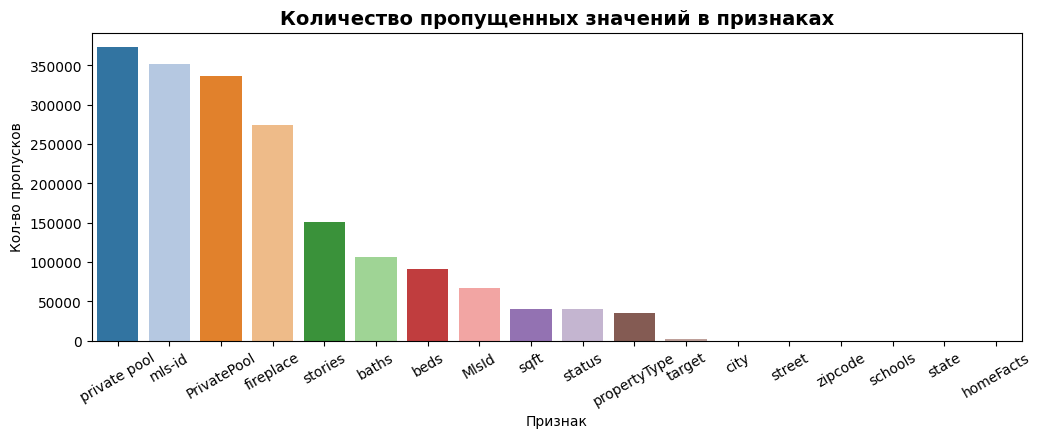

In [5]:
sns_barplot(
    data=   count_of_empty_values,
    title=  'Количество пропущенных значений в признаках')

В данных присутсвует много пропусков, поодавляющее большинство которых находится в признаках **"private pool"**, **"mls-id"**, **"PrivatePool"**, **"fireplace"**

## 1.2 Дублирование признаков

Можно заметить что некоторые признаки повторяются:
* **"private pool"** и **"PrivatePool"**
* **"mls-id"** и **"MlsId"**

In [6]:
df[['private pool', 'PrivatePool', 'mls-id', 'MlsId']].head(5)

,private pool,PrivatePool,mls-id,MlsId
0,NaN,NaN,NaN,611019
1,NaN,NaN,NaN,201916904
2,NaN,yes,NaN,FR19221027
3,NaN,NaN,NaN,14191809
4,NaN,NaN,NaN,861745


In [7]:
feature_list = ['private pool', 'PrivatePool', 'mls-id', 'MlsId']

print('Количество уникальных значений:')
display(df[feature_list].nunique())

Количество уникальных значений:


private pool         1
PrivatePool          2
mls-id           24907
MlsId           232944
dtype: int64

In [8]:
print('Список уникальных значений:\n')
for feature in feature_list:
    print(f'{feature} - {df[feature].unique()}')

Список уникальных значений:

private pool - [nan 'Yes']
PrivatePool - [nan 'yes' 'Yes']
mls-id - [nan '19221142' 'SR19195113' ... 'CV19260192' '7690588' 'F10202858']
MlsId - ['611019' '201916904' 'FR19221027' ... '2152007' '219049831' '10374233']


Поскольку признаки дублируют друг друга, стоит объединить как информацию по наличию бассейнов в формате 1 = есть, 0 = нет, так и информацию по ID службы множественного листинга.

## 1.3 Количество уникальных значений в признаках

In [9]:
unique_values            = df.nunique().values
percentage_unique_values = (unique_values / df.shape[0]) * 100

count_of_unique_values = pd.DataFrame({
    'Признак': df.columns, 
    'Кол-во уникальных значений': unique_values,
    'Доля в %': percentage_unique_values.round()
}).sort_values(
    by='Кол-во уникальных значений', 
    ascending=False, 
    ignore_index=True
)

display(count_of_unique_values)

,Признак,Кол-во уникальных значений,Доля в %
0,street,337076,89.0
1,homeFacts,321009,85.0
2,schools,297365,79.0
3,MlsId,232944,62.0
4,target,43939,12.0
5,sqft,25405,7.0
6,mls-id,24907,7.0
7,zipcode,4549,1.0
8,city,2026,1.0
9,fireplace,1652,0.0


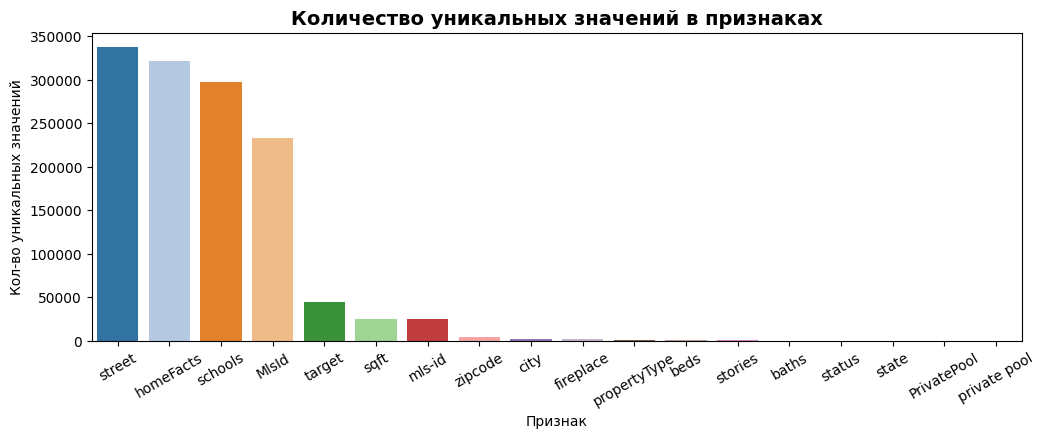

In [10]:
sns_barplot(
    count_of_unique_values,
    'Количество уникальных значений в признаках')

Больше всего уникльных значений присутсвует в названии улиц (**street**), информации о домах (**homeFacts**), информации о школах (**schools**) и номерах службы множественного листинга (**Mlsid**). Причем **street** и **Mlsid** на самом деле несут в себе уникальную офнормацию, а вот **homeFacts** и **school** состоят из множеста дополнительных записей, которые стоит обработать дополнительно.

# 2. Обработка признаков

Поскольку признаков не так много, пройдемся по каждому и выполним их предобработку

## 2.1 status (статус недвижимости)

In [11]:
df_value_counts(df['status']).head()

Количество уникальных значений: 159


,Значение,Кол-во,Доля %
0,for sale,156104,46.3
1,Active,105207,31.2
2,For sale,43465,12.9
3,foreclosure,6426,1.9
4,New construction,5475,1.6


Сразу видно, что есть повторяющиеся статусы с разным регистром, приведем все значения к нижнему регистру

In [12]:
df['status'] = df['status'].str.replace(' / ', ' ') # замена символа "/" на пробел
df['status'] = df['status'].str.strip()             # удаление лишних пробелов
df['status'] = df['status'].str.lower()             # перевод в нижний регистр

Изучив список статусов, можно сгруппировать их следующим образом - если в строке присутвует однин из статусов приведенного ниже списка, то вся строка меняется на этот статус

In [13]:
status_list = ['for sale', 'active', 'foreclosure', 'new', 'pending', 
               'pre-foreclosure', 'under contract', 'contingent', 
               'price change', 'auction', 'foreclosed', 'for rent', 
               'recently sold', 'back on market', 'closed', 
               'coming soon', 'contract']

for status in status_list:
    df["status"] = df["status"].str.replace(f".*{status}.*", status, regex=True)

In [14]:
df_value_counts(df['status']).head()

Количество уникальных значений: 35


,Значение,Кол-во,Доля %
0,for sale,199571,59.2
1,active,106555,31.6
2,foreclosure,10450,3.1
3,new,6165,1.8
4,pending,5364,1.6


Оставим только первые два значения **'for sale'** и **'active'**, так как они занимают 90.8 % данных. Остальные значения заменим на **'other'**

In [15]:
value_list  = df['status'].value_counts()[2:].index     # список значений, подлежащих замене
mask        = df['status'].isin(value_list)             # маска для значений, подлежащих замене

df.loc[mask, 'status'] = 'other'                        # замена значений на 'other'

In [16]:
missing_values(df['status'])

Количество пропущенных значений 39918, что составляет 11 % от общего количества записей


In [17]:
qty_statuses =  df_value_counts(df['status'], 'Статус объекта')

qty_statuses

Количество уникальных значений: 3


,Статус объекта,Кол-во,Доля %
0,for sale,199571,59.2
1,active,106555,31.6
2,other,31141,9.2


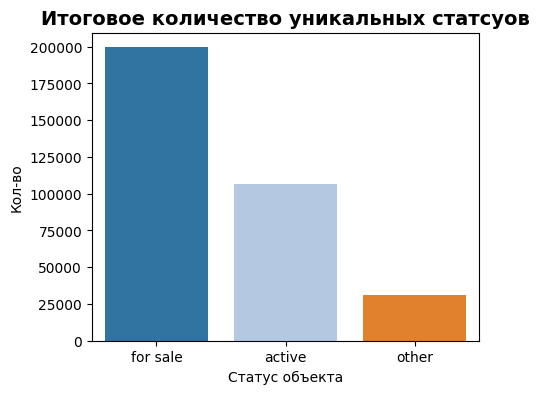

In [18]:
sns_barplot(
    data=   qty_statuses, 
    title=  'Итоговое количество уникальных статсуов',
    size=   (5, 4),
    rotate= 0
)

## 2.2 private pool и PrivatePool (наличие бассейна)

In [19]:
print('Уникальные значения признаков:')
print(f'private pool: {df["private pool"].unique()}')
print(f'PrivatePool:  {df["PrivatePool"].unique()}')

Уникальные значения признаков:
private pool: [nan 'Yes']
PrivatePool:  [nan 'yes' 'Yes']


Приведем все значения к нижнему регистру

In [20]:
df['private pool'] = df['private pool'].str.strip()    # удаление лишних пробелов
df['private pool'] = df['private pool'].str.lower()    # перевод в нижний регистр

df['PrivatePool'] = df['PrivatePool'].str.strip()      # удаление лишних пробелов
df['PrivatePool'] = df['PrivatePool'].str.lower()      # перевод в нижний регистр

print('Количество уникальных признаков "yes":')
print(f'private pool: {df["private pool"].value_counts().values[0]}')
print(f'PrivatePool:  {df["PrivatePool"].value_counts().values[0]}')

Количество уникальных признаков "yes":
private pool: 4181
PrivatePool:  40311


Объединим признаки следующим образом, в признак **PrivatePool** (по скольку в нем больше всего непустых значений) добавим значения из признака **private pool**.

Затем выполним кодирование признаков:
* yes = 1
* nan = 0

In [21]:
df['private_pool'] = df['PrivatePool'].combine_first(df['private pool'])    # объединение признаков

df['private_pool'] = df['private_pool'].fillna(0)                           # замена nan на 0
df['private_pool'] = df['private_pool'].replace({'yes': 1})                 # замена yes на 1

df = df.drop(['private pool', 'PrivatePool'], axis=1)                       # удаление исходных признаков

df.head(2)

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,private_pool
0,active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,611019,"$418,000",0
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,201916904,"$310,000",0


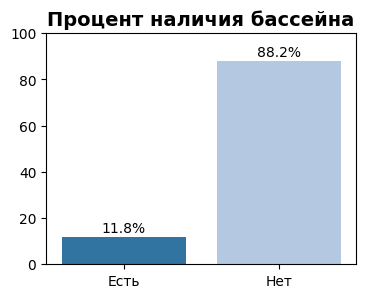

In [22]:
sns_barplot_binary(
    data=   df['private_pool'],
    title=  'Процент наличия бассейна'
)

## 2.3 propertyType (тип недвижимости)

In [23]:
df_value_counts(df["propertyType"]).head()

Количество уникальных значений: 1280


,Значение,Кол-во,Доля %
0,single-family home,92206,26.9
1,Single Family,62869,18.4
2,Single Family Home,31728,9.3
3,condo,25968,7.6
4,lot/land,20552,6.0


Очистка данных и приведение значений к нижнему регистру

In [24]:
df['propertyType'] = df['propertyType'].str.replace(r'[^a-zA-Z0-9\s]', ' ', regex=True)
df['propertyType'] = df['propertyType'].str.replace('\s+', ' ', regex=True)
df['propertyType'] = df['propertyType'].str.strip()
df['propertyType'] = df['propertyType'].str.lower()

print(f'Количество уникальных значений propertyType: {df["propertyType"].nunique()}')

Количество уникальных значений propertyType: 1255


Сгруппируем признаки по типу строения: квартира, дом, ранчо, участок, бунгало и т.п.


In [25]:
propertyType = ['apartment', 'home', 'farm', 'ranch', 'land', 'loft', 
               'bungalow', 'triplex', 'duplex', 'patio', 'other', 
               'condo', 'high rise', 'modern', 'contemporary', 
               'townhouse', 'cottage', 'penthouse']

for property in propertyType:
    df["propertyType"] = df["propertyType"].str.replace(f".*{property}.*", property, regex=True)

В данных присутсвует тип **land** (земельный участок) удалим его, поскольку по условию задания, необходимо предсказывать стоимость домов (возможно квартир), но не земельных участков.

In [26]:
df = df.loc[df['propertyType'] != 'land']   # удаление значений land

Изучив типы недвижимости, был составлен словарь типов для дополнительной группировки.

In [27]:
replacement_dictionary = {
    'apartment':         ['apartment', 'condo', 'single level'],
    'house':             ['home', 'single family', 'single detached', 'detached', 'cottage'],
    'one_storey':        ['1 stor', 'one stor', 'single level', 'one level'],
    'two_storey':        ['2 stor', 'two stor', 'bilevel', 'bi level', '2 level'],
    'three_storey':      ['3 stor', 'tri level', '3 level'],
    'over_four_stories': ['4 stor', '5 stor', '6 stor', '7 stor', '8 stor', 'multi level', '4 level', '5 level'],
    'modern':            ['modern', 'contemporary']}


for key in replacement_dictionary:
    for val in replacement_dictionary[key]:
        df["propertyType"] = df["propertyType"].str.replace(f".*{val}.*", key, regex=True)

In [28]:
qty_types = df_value_counts(df['propertyType'])

qty_types.head(5)

Количество уникальных значений: 309


,Значение,Кол-во,Доля %
0,house,203450,65.4
1,apartment,43892,14.1
2,townhouse,18450,5.9
3,multi family,10715,3.4
4,traditional,5913,1.9


Оставим 4 наиболее популярных типов, все остальные заменим на **other**

In [29]:
value_list = df['propertyType'].value_counts()[4:].index    # список типов недвижимости для замены

mask = df['propertyType'].isin(value_list)                  # маска для значений, подлежащих замене

df.loc[mask, 'propertyType'] = 'other'                      # замена значений на 'other'

In [30]:
qty_types = df_value_counts(df['propertyType'], 'Тип недвижимости')

qty_types

Количество уникальных значений: 5


,Тип недвижимости,Кол-во,Доля %
0,house,203450,65.4
1,apartment,43892,14.1
2,other,34447,11.1
3,townhouse,18450,5.9
4,multi family,10715,3.4


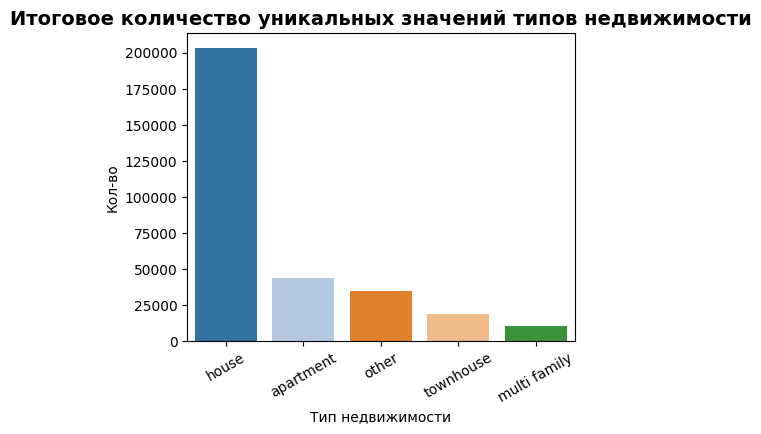

In [31]:
sns_barplot(
    data=   qty_types,
    title=  'Итоговое количество уникальных значений типов недвижимости',
    size=   (5, 4)
)

## 2.4 street (улица)

In [32]:
df_value_counts(df["street"]).head()

Количество уникальных значений: 308970


,Значение,Кол-во,Доля %
0,Address Not Disclosed,632,0.2
1,Undisclosed Address,517,0.1
2,(undisclosed Address),391,0.1
3,Address Not Available,129,0.0
4,Unknown Address,72,0.0


В признаке **street** (улица) слишком много уникальных записей, что логично, поскольку каждый дом или квартира имеют уникальный адрес. К тому же в данных присутсвуют пропуски в виде скрытого адреса.

Удалим этот признак как неинформативный.

In [33]:
df = df.drop('street', axis=1)

df.head(2)

,status,propertyType,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,MlsId,target,private_pool
0,active,house,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,611019,"$418,000",0
1,for sale,house,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,201916904,"$310,000",0


## 2.5 baths (количество ваных комнат)

In [34]:
df_value_counts(df['baths']).head()

Количество уникальных значений: 228


,Значение,Кол-во,Доля %
0,2 Baths,52108,19.6
1,3 Baths,35400,13.3
2,2,20448,7.7
3,2.0,16576,6.2
4,4 Baths,14719,5.5


In [35]:
missing_values(df['baths'])

Количество пропущенных значений 79154, что составляет 23 % от общего количества записей


Данные сильно загрязнены, необходимо выполнить целый ряд преобразований

In [36]:
df['baths'] = df['baths'].str.replace(r'[^0-9\.\,\s]', '', regex=True)  # удаление всех символов кроме цифр
df['baths'] = df['baths'].str.replace('\s+', ' ', regex=True)           # замена повторяющихся пробелов на один
df['baths'] = df['baths'].str.strip()                                   # удаление лишних пробелов
df['baths'] = df['baths'].str.replace(',', '.')                         # замена , на . (для float)
df['baths'] = df['baths'].replace('', np.nan)                           # замена пустой строки на nan
df['baths'] = df['baths'].str.split().str[0]                            # берем только первое число из строки
df['baths'] = df['baths'].replace(r'^\.$', np.nan, regex=True)          # замена строки с одной лишь . на nan
df['baths'] = df['baths'].astype(float).round()                         # приеобразование значений в формат float

In [37]:
missing_values(df['baths'], True)

Количество пропущенных значений 80654, что составляет 23 % от общего количества записей
Количество нулевых значений 205, что составляет 0 % от общего количества записей


In [38]:
df_value_counts(df['baths']).head(12)

Количество уникальных значений: 50


,Значение,Кол-во,Доля %
0,2.0,124586,47.0
1,3.0,67602,25.5
2,4.0,34012,12.8
3,1.0,19016,7.2
4,5.0,9444,3.6
5,6.0,5012,1.9
6,7.0,2074,0.8
7,8.0,1271,0.5
8,9.0,545,0.2
9,10.0,348,0.1


Теперь колчиество ванных комнат представлено в виде чисел, но сразу видны проблемы с этим признаком, которые следует убрать на моменте EDA:
* Количество ванных комнат равное 0 (изначально пустые значения)
* Слишком большие значения, такие как 750 комнат, что крайне маловероятно

## 2.6 homeFacts (информация об объекте недвижимости)

Посмотрим на содержимое одного из значений признака

In [39]:
ast.literal_eval(df['homeFacts'][0])['atAGlanceFacts']

[{'factValue': '2019', 'factLabel': 'Year built'},
 {'factValue': '', 'factLabel': 'Remodeled year'},
 {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'},
 {'factValue': '', 'factLabel': 'Cooling'},
 {'factValue': '', 'factLabel': 'Parking'},
 {'factValue': None, 'factLabel': 'lotsize'},
 {'factValue': '$144', 'factLabel': 'Price/sqft'}]

Преобразуем значения признака в список словарей, для последующего извлечения новых признаков

In [40]:
df['homeFacts'] = list(map(lambda row: ast.literal_eval(row)['atAGlanceFacts'], df['homeFacts']))

Извлечем новые признаки и удалим старый (**homeFacts**)

In [41]:
df = pd.concat([df, df['homeFacts'].apply(HF_feature_extraction)], axis=1)

df = df.drop('homeFacts', axis=1)

df.head(2)

,status,propertyType,baths,fireplace,city,schools,sqft,zipcode,beds,state,...,MlsId,target,private_pool,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,active,house,4.0,Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,...,611019,"$418,000",0,2019,,"Central A/C, Heat Pump",,,None,$144
1,for sale,house,3.0,NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,...,201916904,"$310,000",0,2019,,,,,5828 sqft,$159/sqft


### Year built (год постройки)

In [42]:
df_value_counts(df['Year built']).head()

Количество уникальных значений: 228


,Значение,Кол-во,Доля %
0,2019,32052,9.4
1,,31782,9.3
2,2006,7982,2.3
3,2005,7478,2.2
4,2007,7110,2.1


In [43]:
df['Year built'] = df['Year built'].apply(lambda x: np.nan if len(str(x)) == 0 else x)  # замена пустых значений на nan
df['Year built'] = df['Year built'].replace('No Data', np.nan)                          # замена No Data на nan

Проверим корректность значений в признаке **Year built**

In [44]:
yb_errors = df[df['Year built'].str.len() > 4]

yb_errors

,status,propertyType,baths,fireplace,city,schools,sqft,zipcode,beds,state,...,MlsId,target,private_pool,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
77801,active,house,2.0,NaN,Seattle,"[{'rating': ['5', '6', '7', '6', '7', 'NR', 'N...","1,486",98125,3,WA,...,161732709,"$649,990",0,559990649990,,,,,None,$437
354143,active,house,2.0,NaN,Seattle,"[{'rating': ['5', '6', '7', '6', '7', 'NR', 'N...","1,233",98125,3,WA,...,161732708,"$559,990",0,559990649990,,,,,None,$454


Удалим эти значения

In [45]:
df = df.drop(yb_errors.index, axis=0)

In [46]:
missing_values(df['Year built'])

Количество пропущенных значений 36617, что составляет 11 % от общего количества записей


### Remodeled year (год реконструкции)

In [47]:
df_value_counts(df['Remodeled year']).head()

Количество уникальных значений: 151


,Значение,Кол-во,Доля %
0,,169740,53.2
1,2006,5522,1.7
2,2005,4809,1.5
3,2007,4380,1.4
4,2008,3789,1.2


In [48]:
df['Remodeled year'] = df['Remodeled year'].apply(lambda x: np.nan if len(str(x)) == 0 else x)  # замена пустых значений на nan

In [49]:
missing_values(df['Remodeled year'])

Количество пропущенных значений 196309, что составляет 57 % от общего количества записей


Поскольку в признаке с годом реконструкции более 50 % пропущенных значений, удалим его, чтобы не искажать исходные данные.

In [50]:
df = df.drop('Remodeled year', axis=1)

### Heating (отопление)

In [51]:
df_value_counts(df['Heating']).head()

Количество уникальных значений: 1984


,Значение,Кол-во,Доля %
0,Forced Air,81830,23.9
1,,81198,23.7
2,Forced air,51506,15.1
3,Other,28614,8.4
4,No Data,8611,2.5


In [52]:
missing_values(df['Heating'])

Количество пропущенных значений 3533, что составляет 1 % от общего количества записей


Для начала приведем все значения к нижнему регистру и заменим пустые значения на np.nan

In [53]:
df['Heating'] = df['Heating'].str.lower()                   # приведение к нижнему регистру
df['Heating'] = df['Heating'].replace('none', np.nan)       # замена none на nan
df['Heating'] = df['Heating'].replace('', np.nan)           # замена пустого значения на nan

Изучив типы отопления, сгруппируем их по следующему принципу - в приоритете идет центральное отопление, затем электричество, гас и прочее, согласно списку ниже.

In [54]:
heating_list = ['central', 'electric', 'gas', 'air', 
                'propane', 'refrigeration', 'ceiling fan', 
                'window', 'no a/c', 'solar', 'heat pump', 
                'stove', 'baseboard', 'radiant', 'radiator', 
                'steam', 'wall', 'cooling', 'has cooling', 'other']

for heating in heating_list:
    df['Heating'] = df['Heating'].str.replace(f'.*{heating}.*', heating, regex=True)

Возьмем 5 наиболее популярных типов отопления, остальные заменим на **other**

In [55]:
value_list = df['Heating'].value_counts()[5:].index     # список значений для замены

mask = df['Heating'].isin(value_list)                   # маска для значений, подлежащих замене

df.loc[mask, 'Heating'] = 'other'                       # замена значений на 'other'

In [56]:
heating_df = df_value_counts(df['Heating'], 'Тип отопления')

heating_df

Количество уникальных значений: 5


,Тип отопления,Кол-во,Доля %
0,air,138010,52.9
1,other,61886,23.7
2,central,34765,13.3
3,gas,13998,5.4
4,electric,12223,4.7


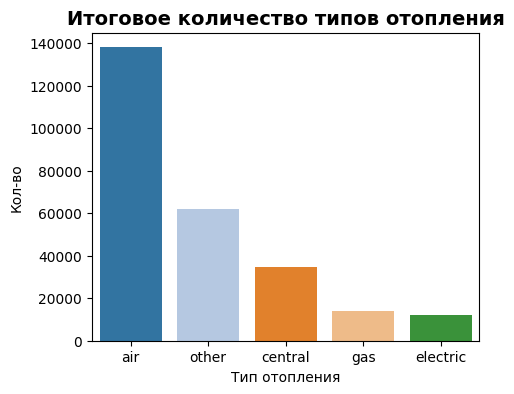

In [57]:
sns_barplot(
    data=   heating_df,
    title=  'Итоговое количество типов отопления',
    size=   (5, 4),
    rotate= 0
)

In [58]:
missing_values(df['Heating'])

Количество пропущенных значений 84803, что составляет 25 % от общего количества записей


### Cooling (охлаждение)

In [59]:
df_value_counts(df['Cooling']).head()

Количество уникальных значений: 1445


,Значение,Кол-во,Доля %
0,Central,157500,46.0
1,,90608,26.5
2,Central Air,14384,4.2
3,No Data,10616,3.1
4,Has Cooling,9730,2.8


In [60]:
missing_values(df['Cooling'])

Количество пропущенных значений 3533, что составляет 1 % от общего количества записей


In [61]:
df['Cooling'] = df['Cooling'].str.lower()                   # переведине к нижнему регистру
df['Cooling'] = df['Cooling'].replace('none', np.nan)       # замена none на nan
df['Cooling'] = df['Cooling'].replace('no data', np.nan)    # замена no data на nan
df['Cooling'] = df['Cooling'].replace('', np.nan)           # замена пустого значения на nan

In [62]:
df_value_counts(df['Cooling']).head()

Количество уникальных значений: 1435


,Значение,Кол-во,Доля %
0,central,157500,67.4
1,central air,14384,6.2
2,has cooling,9730,4.2
3,central electric,6154,2.6
4,wall,3955,1.7


In [63]:
cooling_list = ['central', 'electric', 'gas', 'air', 
                'propane', 'refrigeration', 'ceiling fan', 
                'window', 'no a/c', 'solar', 'heat pump', 
                'stove', 'baseboard', 'radiant', 'radiator', 
                'steam', 'wall', 'cooling', 'has cooling', 'other']

for cooling in cooling_list:
    df['Cooling'] = df['Cooling'].str.replace(f'.*{cooling}.*', cooling, regex=True)

In [64]:
value_list = df['Cooling'].value_counts()[5:].index     # список типов охлаждения для замены

mask = df['Cooling'].isin(value_list)                   # маска для значений, подлежащих замене

df.loc[mask, 'Cooling'] = 'other'                       # замена значений на 'other'

In [65]:
cooling_df = df_value_counts(df['Cooling'], 'Тип охлаждения')

cooling_df

Количество уникальных значений: 5


,Тип охлаждения,Кол-во,Доля %
0,central,203283,86.9
1,cooling,12596,5.4
2,other,10964,4.7
3,wall,4397,1.9
4,refrigeration,2593,1.1


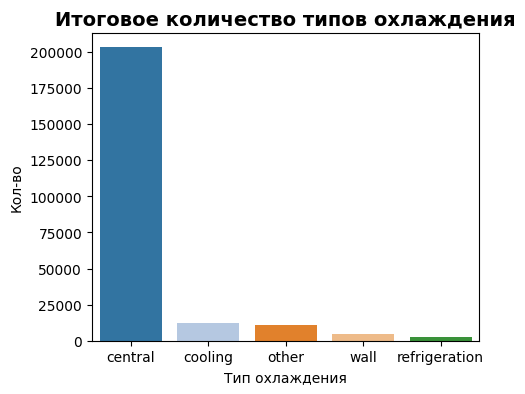

In [66]:
sns_barplot(
    data=   cooling_df,
    title=  'Итоговое количество типов охлаждения',
    size=   (5, 4),
    rotate= 0
)

In [67]:
missing_values(df['Cooling'])

Количество пропущенных значений 111852, что составляет 32 % от общего количества записей


### Parking (парковка)

In [68]:
df_value_counts(df['Parking']).head()

Количество уникальных значений: 3319


,Значение,Кол-во,Доля %
0,,142285,41.6
1,Attached Garage,70121,20.5
2,2 spaces,28063,8.2
3,1 space,14252,4.2
4,No Data,13334,3.9


In [69]:
missing_values(df['Parking'], True)

Количество пропущенных значений 3533, что составляет 1 % от общего количества записей
Количество нулевых значений 0, что составляет 0 % от общего количества записей


In [70]:
df['Parking'] = df['Parking'].str.lower()                   # приведение к нижнему регистру
df['Parking'] = df['Parking'].str.strip()                   # удаление лишних пробелов

df['Parking'] = df['Parking'].replace('no data', np.nan)    # замена no data на nan
df['Parking'] = df['Parking'].replace('none', np.nan)       # замена none на nan
df['Parking'] = df['Parking'].replace('', np.nan)           # замена пустого значения на nan

In [71]:
garage_dictionary = {
    'garage':  ['attached', 'detached', 'garage', 'door', 'basement', 'more'],
    'parking': ['parking', 'street', 'driveway', 'carport', 'spaces', 'gravl', 'covered', 'asphalt', 'open']}


for key in garage_dictionary:
    for val in garage_dictionary[key]:
        df["Parking"] = df["Parking"].str.replace(f".*{val}.*", key, regex=True)

Оставим два наиболее популярных парковочных места, остальное замени мна **other**

In [72]:
value_list = df['Parking'].value_counts()[2:].index     # список типов гаражей для замены

mask = df['Parking'].isin(value_list)                   # маска для значений, подлежащих замене

df.loc[mask, 'Parking'] = 'other'                       # замена значений на 'other'

In [73]:
parking_df = df_value_counts(df['Parking'])

parking_df

Количество уникальных значений: 3


,Значение,Кол-во,Доля %
0,garage,100574,54.6
1,parking,59713,32.4
2,other,23920,13.0


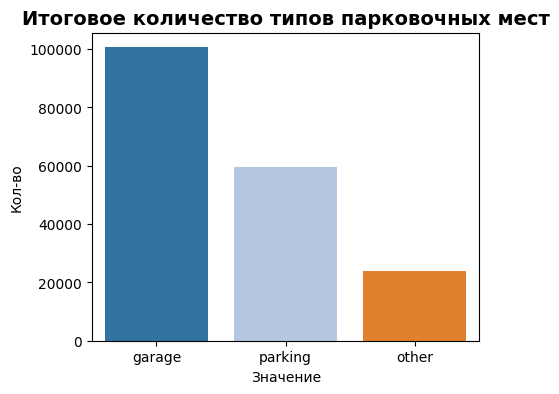

In [74]:
sns_barplot(
    data=   parking_df,
    title=  'Итоговое количество типов парковочных мест',
    size=   (5, 4),
    rotate= 0
)

In [75]:
missing_values(df['Parking'], True)

Количество пропущенных значений 161478, что составляет 47 % от общего количества записей
Количество нулевых значений 0, что составляет 0 % от общего количества записей


### lotsize (площадь земельного участка)

In [76]:
df_value_counts(df['lotsize']).head()

Количество уникальных значений: 34198


,Значение,Кол-во,Доля %
0,,32477,10.2
1,—,25245,8.0
2,No Data,5330,1.7
3,-- sqft lot,3819,1.2
4,0.26 acres,2182,0.7


In [77]:
df['lotsize'] = df['lotsize'].apply(convert_to_sqft)                        # преобразование из acre в sqft
df['lotsize'] = df['lotsize'].str.replace(r'[^0-9\.\,\s]', '', regex=True)  # удаление всех символов кроме цифр
df['lotsize'] = df['lotsize'].str.replace('\s+', ' ', regex=True)           # замена повторяющихся пробелов на один
df['lotsize'] = df['lotsize'].str.replace(' ', '')                          # удаление пробелов в тексте
df['lotsize'] = df['lotsize'].str.strip()                                   # удаление лишних пробелов
df['lotsize'] = df['lotsize'].replace('', np.nan)                           # замена пустого значения на nan
df['lotsize'] = df['lotsize'].replace('No Data', np.nan)                    # замена No Data на nan
df['lotsize'] = df['lotsize'].str.replace(',', '.')                         # замена , на . (для float)
df['lotsize'] = df['lotsize'].str.split('.').str[:2].str.join('.')          # разбиваем значения по точке и берем только первые два элемента
df['lotsize'] = df['lotsize'].astype(float).round(1)                        # преобразование во float и округление

In [78]:
missing_values(df['lotsize'], True)

Количество пропущенных значений 159573, что составляет 46 % от общего количества записей
Количество нулевых значений 1, что составляет 0 % от общего количества записей


### Price/sqft (Цена/кв. фут)

In [79]:
df_value_counts(df['Price/sqft']).head()

Количество уникальных значений: 6416


,Значение,Кол-во,Доля %
0,,5185,1.6
1,No Data,1241,0.4
2,No Info,954,0.3
3,$1/sqft,871,0.3
4,$125/sqft,791,0.3


In [80]:
df['Price/sqft'] = df['Price/sqft'].str.lower()                                     # приведение к нижнему регистру
df['Price/sqft'] = df['Price/sqft'].str.replace('\s+', ' ', regex=True)             # замена повторяющихся пробелов на один
df['Price/sqft'] = df['Price/sqft'].str.strip()                                     # удаление лишних пробелов
df['Price/sqft'] = df['Price/sqft'].str.replace(',', '.')                           # замена , на . (для float)
df['Price/sqft'] = df['Price/sqft'].str.replace(r'[^0-9\.\,]', '', regex=True)      # удаление всех символов кроме цифр
df['Price/sqft'] = df['Price/sqft'].str.replace(r'[$|/sqft]', '', regex=True)       # удаление лишних символов и текста

df['Price/sqft'] = df['Price/sqft'].replace('', np.nan)                             # замена пустого значения на nan
df['Price/sqft'] = df['Price/sqft'].replace('no info', np.nan)                      # замена no info на nan
df['Price/sqft'] = df['Price/sqft'].replace('no daa', np.nan)                       # замена no daa на nan 

df['Price/sqft'] = df['Price/sqft'].str.split('.').str[:2].str.join('.')            # разбиваем значения по точке и берем только первые два элемента
df['Price/sqft'] = df['Price/sqft'].astype(float).round(1)                          # преобразование во float и округление

In [81]:
missing_values(df['Price/sqft'], True)

Количество пропущенных значений 38467, что составляет 11 % от общего количества записей
Количество нулевых значений 121, что составляет 0 % от общего количества записей


После окончательной обработки признаков 'sqft', 'lotsize', 'target', 'Price/sqft' необходимо быудет выполнить их анализ и по возможности рассчитать значение 'sqft' из признаков 'target', 'Price/sqft'

## 2.7 fireplace (наличие камина)

In [82]:
df_value_counts(df["fireplace"]).head()

Количество уникальных значений: 1652


,Значение,Кол-во,Доля %
0,yes,49392,48.4
1,Yes,20856,20.4
2,1,14544,14.2
3,2,2431,2.4
4,Not Applicable,1993,2.0


Поскольку уникальных записей достаточно много, сразу выполним очистку данных.

Заменим все отрицательные типы (not applicable, 0, no и т.п.) на **0**, а положительные (yes, 1, 2, living room и т.п.) на **1**

In [83]:
df['fireplace'] = df['fireplace'].str.strip()               # удаление лишних пробелов
df['fireplace'] = df['fireplace'].str.lower()               # приведение к нижнему регистру
df['fireplace'] = df['fireplace'].fillna(0)                 # замена nan на 0

zero_types = ['not applicable', '0', 'n/k', 'no']           # список типов для замены

df['fireplace'] = df['fireplace'].replace(zero_types, 0)    # замена значений на 0
df.loc[df['fireplace'] != 0, 'fireplace'] = 1               # замена значений на 1

In [84]:
df['fireplace'] = df['fireplace'].astype(int)               # преобразование в целочисленный формат

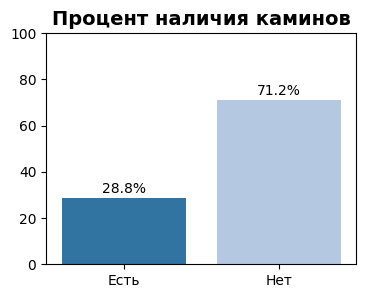

In [85]:
sns_barplot_binary(
    data=   df['fireplace'],
    title=  'Процент наличия каминов'
)

## 2.8 city (город)

Посмотрим на процент наиболее часто встречающихся городов

In [86]:
df_value_counts(df['city']).head()

Количество уникальных значений: 1915


,Значение,Кол-во,Доля %
0,Houston,23333,6.7
1,Miami,15391,4.5
2,San Antonio,15114,4.4
3,Jacksonville,9595,2.8
4,Dallas,8544,2.5


In [87]:
missing_values(df['city'])

Количество пропущенных значений 9, что составляет 0 % от общего количества записей


Сформируем список городов, процент которых меньше или равен нулю и заменим их на **other**

In [88]:
result = round(df['city'].value_counts(normalize=True) * 100, 1)    # процент городов, округленный до десятых
result = result[result <= 0].index                                  # список значений для удаления

df['city'] = df['city'].replace(result, 'other')                    # замена городов из списка на other
df['city'] = df['city'].fillna('other')                             # замена пустых значений на other

In [89]:
qty_citys = df_value_counts(df['city'], 'Название городов')

qty_citys.head(5)

Количество уникальных значений: 256


,Название городов,Кол-во,Доля %
0,other,42847,12.4
1,Houston,23333,6.7
2,Miami,15391,4.5
3,San Antonio,15114,4.4
4,Jacksonville,9595,2.8


## 2.9 schools (школы)

Посмотрим на содержимое одного значения

In [90]:
ast.literal_eval(df['schools'][0])

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'],
  'data': {'Distance': ['2.7 mi',
    '3.6 mi',
    '5.1 mi',
    '4.0 mi',
    '10.5 mi',
    '12.6 mi',
    '2.7 mi',
    '3.1 mi'],
   'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']},
  'name': ['Southern Pines Elementary School',
   'Southern Middle School',
   'Pinecrest High School',
   'Southern Pines Primary School',
   "Crain's Creek Middle School",
   'Union Pines High School',
   'Episcopal Day Private School',
   'Calvary Christian Private School']}]

Извлечем данные в новые признаки:
* schools_rating - Рейтинг учебных заведений по 10-ти бальной шкале. Возьмем из этого признака минимальный, средний и максимальный бал в качестве новых признаков, затем удалим его.
    * **schools_rating_min**
    * **schools_rating_mean**
    * **schools_rating_max**
* schools_distance - Рассотяние до школ. Так же, возьмем минимальное, среднее и максимальное значение в качестве новых признаков.
    * **schools_distance_min**
    * **schools_distance_mean**
    * **schools_distance_max**
* schools_grades - Уровень вколы. Создадим новые признаки, в которых будет указано количество школ каждого уровня.
    * **PK–2 (pre-kindergarten)**
    * **3–5 (basic_school)**
    * **6–8 (middle_school)**
    * **9–12 (high_school)**
    * **PK–5 (pre-kindergarten-basic_school)**
    * **K–12 (kindergarten-high_school)**
* **schools_count** - Количество школ рядом

In [91]:
df['schools_rating']    = df['schools'].apply(lambda x: ast.literal_eval(x)[0]['rating'])
df['schools_distance']  = df['schools'].apply(lambda x: ast.literal_eval(x)[0]['data']['Distance'])
df['schools_grades']    = df['schools'].apply(lambda x: ast.literal_eval(x)[0]['data']['Grades'])
df['schools_count']     = df['schools'].apply(lambda x: len(ast.literal_eval(x)[0]['name']))

### schools_rating

In [92]:
df["schools_rating"].head()

0    [4, 4, 7, NR, 4, 7, NR, NR]
1          [4/10, None/10, 4/10]
2             [8/10, 4/10, 8/10]
3      [9/10, 9/10, 10/10, 9/10]
5                             []
Name: schools_rating, dtype: object

Данные необходимо очистить следующим образом:
* 'NR' и 'NA' - заменить на np.nan
* '/10' и 'None' - удалить

In [93]:
df['schools_rating'] = df['schools_rating'].apply(clean_school_rating)

df["schools_rating"].head()

0    [4, 4, 7, nan, 4, 7, nan, nan]
1                          [4, , 4]
2                         [8, 4, 8]
3                     [9, 9, 10, 9]
5                                []
Name: schools_rating, dtype: object

Посчитаем количество пропусков в данных

In [94]:
nan_values   = np.concatenate(df['schools_rating'].values) == 'nan'
nan_percent = round((sum(nan_values) / len(nan_values)) * 100)

print(f'Количество пропусков {sum(nan_values)}, что составляет {nan_percent} % от общего количества оценок')

Количество пропусков 133931, что составляет 9 % от общего количества оценок


Определим самое распространенное значение

In [95]:
values = np.concatenate(df['schools_rating'].dropna().values).ravel()   # преобразование списков в одномерный массив чисел
common = pd.Series(values).mode()[0]                                    # подсчет самого распространенного значения

print(f'Самая распространенная оценка: {common}')

Самая распространенная оценка: 3


Замена пустых значений на самую распространенную оценку

In [96]:
df['schools_rating'] = df['schools_rating'].apply(lambda x: [0] if len(x) == 0 else x)                              # замена пустой строки
df['schools_rating'] = df['schools_rating'].apply(lambda x: [common if pd.isna(value) else value for value in x])   # замена nan
df['schools_rating'] = df['schools_rating'].apply(lambda x: [common if value == '' else value for value in x])      # замена пустого значения
df['schools_rating'] = df['schools_rating'].apply(lambda x: list(map(int, x)))                                      # преобразование в число

df['schools_rating'].head()

0    [4, 4, 7, 3, 4, 7, 3, 3]
1                   [4, 3, 4]
2                   [8, 4, 8]
3               [9, 9, 10, 9]
5                         [0]
Name: schools_rating, dtype: object

Создание новых признаков

In [97]:
df['schools_rating_min']    = df['schools_rating'].apply(lambda x: min(x) if x else None)
df['schools_rating_mean']   = df['schools_rating'].apply(lambda x: round(sum(x) / len(x), 1) if x else None)
df['schools_rating_max']    = df['schools_rating'].apply(lambda x: max(x) if x else None)

df.head(2)

,status,propertyType,baths,fireplace,city,schools,sqft,zipcode,beds,state,...,Parking,lotsize,Price/sqft,schools_rating,schools_distance,schools_grades,schools_count,schools_rating_min,schools_rating_mean,schools_rating_max
0,active,house,4.0,1,other,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,...,NaN,NaN,144.0,"[4, 4, 7, 3, 4, 7, 3, 3]","[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...","[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]",8,3,4.4,7
1,for sale,house,3.0,0,other,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,...,NaN,5828.0,159.0,"[4, 3, 4]","[1.65mi, 1.32mi, 1.01mi]","[9-12, 3-8, PK-8]",3,3,3.7,4


### schools_distance

In [98]:
df['schools_distance'].head()

0    [2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...
1                             [1.65mi, 1.32mi, 1.01mi]
2                             [1.19mi, 2.06mi, 2.63mi]
3                      [1.05mi, 0.1mi, 1.05mi, 0.81mi]
5                                                   []
Name: schools_distance, dtype: object

Очистка данных

In [99]:
df['schools_distance'] = df['schools_distance'].apply(clean_school_values)

In [100]:
df['schools_distance'].head()

0    [2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]
1                            [1.65, 1.32, 1.01]
2                            [1.19, 2.06, 2.63]
3                       [1.05, 0.1, 1.05, 0.81]
5                                            []
Name: schools_distance, dtype: object

In [101]:
df['schools_distance'] = df['schools_distance'].apply(lambda x: [0] if len(x) == 0 else x)      # замена пустой строки на 0
df['schools_distance'] = df['schools_distance'].apply(lambda x: list(map(float, x)))            # преобразование во float

Создание новых признаков

In [102]:
df['schools_distance_min']  = df['schools_distance'].apply(lambda x: min(x) if x else None)
df['schools_distance_mean'] = df['schools_distance'].apply(lambda x: round(sum(x) / len(x), 1) if x else None)
df['schools_distance_max']  = df['schools_distance'].apply(lambda x: max(x) if x else None)

df.head(2)

,status,propertyType,baths,fireplace,city,schools,sqft,zipcode,beds,state,...,schools_rating,schools_distance,schools_grades,schools_count,schools_rating_min,schools_rating_mean,schools_rating_max,schools_distance_min,schools_distance_mean,schools_distance_max
0,active,house,4.0,1,other,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,...,"[4, 4, 7, 3, 4, 7, 3, 3]","[2.7, 3.6, 5.1, 4.0, 10.5, 12.6, 2.7, 3.1]","[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]",8,3,4.4,7,2.70,5.5,12.60
1,for sale,house,3.0,0,other,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,...,"[4, 3, 4]","[1.65, 1.32, 1.01]","[9-12, 3-8, PK-8]",3,3,3.7,4,1.01,1.3,1.65


### schools_grades

In [103]:
df['schools_grades'].head()

0    [3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]
1                                [9-12, 3-8, PK-8]
2                                 [6-8, K-5, 9-12]
3                           [5-6, PK-4, 7-8, 9-12]
5                                               []
Name: schools_grades, dtype: object

Определение количества пропусков в значениях

In [104]:
# применение функции к каждому элементу столбца 'schools_grades'
empty_nan_values = df['schools_grades'].apply(check_empty_nan)

# вывод значений, в списках которых есть пустые или NaN значения
result = df['schools_grades'][empty_nan_values]

print(f'Пропуски присутствуют в {result.shape[0]} записях')

Пропуски присутствуют в 257 записях


Самая распространенная классификация уровней школ в США подразумевает следующие уровни:
* **PK (Pre-Kindergarten)** - Дошколное образование (ясли)
* **K (Kindergarten)** - Детский садик
* **Elementary School** - Начальная школа (1-5 класс)
* **Middle School** - Средняя школа (6-8 класс)
* **High School** - Высшая школа (9-12 класс)

При это каждый уровень образования может быть расширен, к примеру с ясли до 5 класса, с детского сада до 12 класса и т.п.

Исходя из этого, уровни школ будут сгруппированы по следующему принципу:
* **grade_PK** - Ясли
* **grade_PK_5** - Ясли - Начальная школа
* **grade_PK_8** - Ясли - Средняя школа
* **grade_PK_12** - Ясли - Высшая школа
* 
* **grade_K_5** - Детский садик - Начальная школа
* **grade_K_8** - Детский садик - Средняя школа
* **grade_K_12** - Детский садик - Высшая школа
* 
* **grade_1_5** - Начальная школа
* **grade_6_8** - Средняя школа
* **grade_9_12** - Высшая школа

In [105]:
grade_PK      = ['PK', 'PK-K']
grade_PK_5    = ['PK-1', 'PK-2', 'PK-3', 'PK-4', 'PK-5', 'Pk-5']
grade_PK_8    = ['PK-6', 'PK-7', 'PK-8']
grade_PK_12   = ['PK-9', 'PK-10', 'PK-11', 'PK-12']

grade_K_5     = ['K-1', 'K-2', 'K-3', 'K-4', 'K-5']
grade_K_8     = ['K-6', 'K-7', 'K-8']
grade_K_12    = ['K-9', 'K-10', 'K-11', 'K-12']

grade_1_5     = ['1', '1-2', '1-3', '1-4', '1-5', '2', '2-3', '2-4', 
                 '2-5', '3', '3-4', '3-5', '4', '4-5', '5']
grade_6_8     = ['1-6', '1-7', '1-8', '2-6', '2-7', '2-8', '3-6', 
                 '3-7', '3-8', '4-6', '4-7', '4-8', '5-6', '5-7', 
                 '5-8', '6', '6-7', '6-8', '7', '7-8', '8']
grade_9_12    = ['1-9', '1-10', '1-11', '1-12', '2-9', '2-11', '2-12', 
                 '3-10', '3-11', '3-12', '4-9', '4-10', '4-11', '4-12', 
                 '5-9', '5-10', '5-11', '5-12', '6-9', '6-10', '6-11', 
                 '6-12', '7-9', '7-10', '7-11', '7-12', '8-9', '8-10', 
                 '8-11', '8-12', '9', '9-10', '9-11', '9-12', '10', 
                 '10-11', '10-12', '11', '11-12', '12']

In [106]:
def clean_school_grades(lst: list) -> list:
    """
    Очистка и группировка школ по типу

    Args:
        lst (list): список значений

    Returns:
        list:       обработанный список
    """
    
    clean_lst = []
    
    for value in lst:
        if isinstance(value, str):
            value = value.split(',')[0]
            clean_value = re.sub(r'(Preschool to )', 'PK-', value)
            clean_value = re.sub(r'( to )', '-', clean_value)
            clean_value = re.sub(r'(N\/A|NA)', '', clean_value)
            
            clean_value = clean_value.replace('–', '-')

            parts = clean_value.upper().split('-')
            if len(parts) == 2 and parts[0] == parts[1]:
                clean_value = parts[0]
            
            clean_value = 'PK' if clean_value in grade_PK else clean_value
            clean_value = 'PK-5' if clean_value in grade_PK_5 else clean_value
            clean_value = 'PK-8' if clean_value in grade_PK_8 else clean_value
            clean_value = 'PK-12' if clean_value in grade_PK_12 else clean_value
            clean_value = 'K-5' if clean_value in grade_K_5 else clean_value
            clean_value = 'K-8' if clean_value in grade_K_8 else clean_value
            clean_value = 'K-12' if clean_value in grade_K_12 else clean_value
            clean_value = '1-5' if clean_value in grade_1_5 else clean_value
            clean_value = '6-8' if clean_value in grade_6_8 else clean_value
            clean_value = '9-12' if clean_value in grade_9_12 else clean_value
            
            clean_lst.append(clean_value.strip())
        else:
            clean_lst.append(value)
            
    return clean_lst

In [107]:
df['schools_grades'] = df['schools_grades'].apply(clean_school_grades)

Количество значений в каждом уровне школ

In [108]:
pd.Series(np.concatenate(df['schools_grades'].dropna().values)).value_counts()

9-12     456815
6-8      342914
PK-5     273031
PK-8     139330
K-5       77700
K-8       63041
PK-12     43689
K-12      37232
1-5        7843
K          1284
           1156
PK          949
Name: count, dtype: int64

Поскольку в данных присутсвуют пропуски (в небольшом количестве), заменим их на самое распространенное значение

In [109]:
values = np.concatenate(df['schools_grades'].dropna().values).ravel()   # преобразование списков в одномерный массив
common = pd.Series(values).mode()[0]                                    # определение самого распространенного значения

print(f'Самый распространенный тип школы: {common}')

Самый распространенный тип школы: 9-12


In [110]:
df['schools_grades'] = df['schools_grades'].apply(lambda x: [common if value == '' else value for value in x])      # замена пустого значения
df['schools_grades'] = df['schools_grades'].apply(lambda x: [common if pd.isna(value) else value for value in x])   # замена None

Подсчет количества школ каждого уровня

In [111]:
df['schools_PK–2']  = df['schools_grades'].apply(lambda x: count_schools_grades(x, 'PK'))
df['schools_PK-5']  = df['schools_grades'].apply(lambda x: count_schools_grades(x, 'PK-5'))
df['schools_PK-8']  = df['schools_grades'].apply(lambda x: count_schools_grades(x, 'PK-8'))
df['schools_PK-12'] = df['schools_grades'].apply(lambda x: count_schools_grades(x, 'PK-12'))

df['schools_K']     = df['schools_grades'].apply(lambda x: count_schools_grades(x, 'K'))
df['schools_K-5']   = df['schools_grades'].apply(lambda x: count_schools_grades(x, 'K-5'))
df['schools_K-8']   = df['schools_grades'].apply(lambda x: count_schools_grades(x, 'K-8'))
df['schools_K-12']  = df['schools_grades'].apply(lambda x: count_schools_grades(x, 'K-12'))

df['schools_1-5']   = df['schools_grades'].apply(lambda x: count_schools_grades(x, '1-5'))
df['schools_6-8']   = df['schools_grades'].apply(lambda x: count_schools_grades(x, '6-8'))
df['schools_9-12']  = df['schools_grades'].apply(lambda x: count_schools_grades(x, '9-12'))

In [112]:
df.head(2)

,status,propertyType,baths,fireplace,city,schools,sqft,zipcode,beds,state,...,schools_PK-5,schools_PK-8,schools_PK-12,schools_K,schools_K-5,schools_K-8,schools_K-12,schools_1-5,schools_6-8,schools_9-12
0,active,house,4.0,1,other,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,...,2,0,0,3,2,0,1,1,2,2
1,for sale,house,3.0,0,other,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,...,0,1,0,1,0,1,0,0,1,1


In [113]:
data_values = df.loc[:, 'schools_PK–2':].sum()

schools_grades_df  = pd.DataFrame({
    'Уровень оразования':   data_values.index,
    'Кол-во':               data_values.values
})

display(schools_grades_df)

print(f'Количество уникальных значений: {data_values.nunique()}')

,Уровень оразования,Кол-во
0,schools_PK–2,456999
1,schools_PK-5,273031
2,schools_PK-8,139330
3,schools_PK-12,43689
4,schools_K,636256
5,schools_K-5,350731
6,schools_K-8,202371
7,schools_K-12,80921
8,schools_1-5,7843
9,schools_6-8,342914


Количество уникальных значений: 11


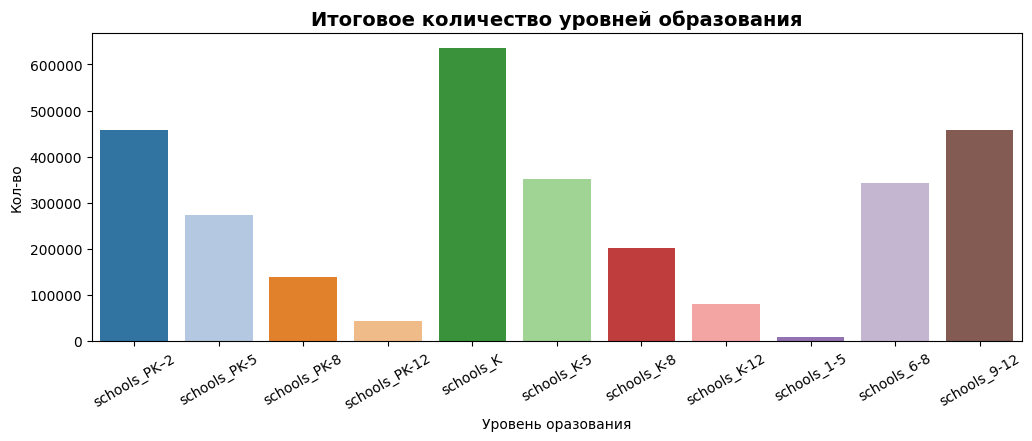

In [114]:
sns_barplot(
    data=   schools_grades_df,
    title=  'Итоговое количество уровней образования'
)

На присутсвует интересное наблюдение, больше всего распространены уровни образования от ясли (*Pre-Kindergarten* - PK) и детского сада (*Kindergarten* - K) до 2 и 5 классов, затем родители предпочитают отдавать детей в среднюю (*Middle School* - 6-8) и старшую школу (*High School* - 9-12).

Удалим неиспользуемые признаки

In [115]:
del_list = ['schools', 'schools_rating', 'schools_distance', 
            'schools_grades', 'schools_count']

df = df.drop(del_list, axis=1)

## 2.10 sqft (площадь)

In [116]:
df_value_counts(df['sqft']).head()

Количество уникальных значений: 24930


,Значение,Кол-во,Доля %
0,0,948,0.3
1,"1,200 sqft",814,0.3
2,"1,000 sqft",639,0.2
3,"1,100 sqft",566,0.2
4,"1,800 sqft",556,0.2


In [117]:
missing_values(df['sqft'])

Количество пропущенных значений 24105, что составляет 7 % от общего количества записей


Для начала очистим признак от текстовых значений и приведем его к float

In [118]:
df['sqft'] = df['sqft'].str.replace(r'[^0-9\.\,\s]', '', regex=True)    # удаление всех символов кроме цифр
df['sqft'] = df['sqft'].str.replace('\s+', ' ', regex=True)             # замена повторяющихся пробелов на один
df['sqft'] = df['sqft'].str.strip()                                     # удаление лишних пробелов
df['sqft'] = df['sqft'].str.replace(',', '.')                           # замена , на . (для float)
df['sqft'] = df['sqft'].replace('', np.nan)                             # замена пустой строки на nan
df['sqft'] = df['sqft'].str.split('.').str[:2].str.join('.')            # разбиваем значения по точке и берем только первые два элемента
df['sqft'] = df['sqft'].astype(float).round(1)                          # преобразование во float и округление

In [119]:
missing_values(df['sqft'], True)

Количество пропущенных значений 24925, что составляет 7 % от общего количества записей
Количество нулевых значений 948, что составляет 0 % от общего количества записей


## 2.11 zipcode (почтовый индекс)

In [120]:
df_value_counts(df['zipcode']).head()

Количество уникальных значений: 4476


,Значение,Кол-во,Доля %
0,33131,1562,0.5
1,78245,1388,0.4
2,34747,1335,0.4
3,33132,1327,0.4
4,33137,1298,0.4


In [121]:
missing_values(df['zipcode'], True)

Количество пропущенных значений 0, что составляет 0 % от общего количества записей
Количество нулевых значений 0, что составляет 0 % от общего количества записей


Почтовый индекс не несет какой-либо значимой информации, можно удалить его

In [122]:
df = df.drop('zipcode', axis=1)

## 2.12 beds (количество спален)

In [123]:
df_value_counts(df['beds']).head()

Количество уникальных значений: 1181


,Значение,Кол-во,Доля %
0,3 Beds,52432,18.5
1,4 Beds,34981,12.3
2,3,31402,11.1
3,2 Beds,25702,9.1
4,4,20028,7.1


В данных присутсвуют значения не в виде количества комнат, а в виде площади. посмотрим на количество таких значений

In [124]:
# количество записей с площадью
sqft_df = df.fillna('')

sqft_count      = sqft_df[sqft_df['beds'].str.contains('sqft')].shape[0]
sqft_indexes    = sqft_df[sqft_df['beds'].str.contains('sqft')].index
sqft_percent    = round((sqft_count / df.shape[0]) * 100)

acres_count     = sqft_df[sqft_df['beds'].str.contains('acres')].shape[0]
acres_indexes   = sqft_df[sqft_df['beds'].str.contains('acres')].index
acres_percent   = round((acres_count / df.shape[0]) * 100)

print(f'Количество записей с площадью {sqft_count + acres_count}, что составляет {sqft_percent + acres_percent} % от общего количества значений')

Количество записей с площадью 3027, что составляет 0 % от общего количества значений


In [125]:
missing_values(df['beds'])

Количество пропущенных значений 62391, что составляет 18 % от общего количества записей


Заменим значения с площадью на 1, будем считать, что указана площадь одной спальни

In [126]:
df.loc[sqft_indexes, 'beds']    = 1                                         # замена значений с площадью (sqft) на 1
df.loc[acres_indexes, 'beds']   = 1                                         # замена значений с площадью (acres) на 1

df['beds'] = df['beds'].str.replace(r'[^0-9]', '', regex=True)              # удаление всех, нечисловых символов
df['beds'] = df['beds'].str.replace('\s+', ' ', regex=True)                 # замена множественных пробелов на один
df['beds'] = df['beds'].apply(lambda x: np.nan if len(str(x)) == 0 else x)  # замена пустой строки на nan
df['beds'] = df['beds'].str.strip()                                         # удаление лишних пробелов
df['beds'] = df['beds'].astype(float)                                       # преобразование во float

Удалим значения, в которых более 60 спален, так как такие значения могут сильно исказить результаты модели

In [127]:
drop_list = df[df['beds'] > 60].index

print(f'Количество объектов недвижимости с более чем 60 спальнями: {len(drop_list)} шт.')

df = df.drop(drop_list, axis=0)

Количество объектов недвижимости с более чем 60 спальнями: 149 шт.


In [128]:
missing_values(df['beds'])

Количество пропущенных значений 82899, что составляет 24 % от общего количества записей


В данных достаточно большое количество пропусков и явных выбросов. Необходимо дополнительно обработать этот признак в дальнейшем

## 2.13 state (штат)

In [129]:
df['state'].unique()

array(['NC', 'WA', 'CA', 'TX', 'PA', 'FL', 'TN', 'IA', 'NY', 'OR', 'DC',
       'NV', 'GA', 'IL', 'NJ', 'MA', 'IN', 'OH', 'UT', 'MI', 'VT', 'AZ',
       'MD', 'CO', 'VA', 'KY', 'MO', 'WI', 'ME', 'MS', 'OK', 'SC', 'MT',
       'DE', 'Fl', 'BA', 'OT', 'OS'], dtype=object)

In [130]:
state_df = df_value_counts(df['state'], value='Штат')

state_df.head()

Количество уникальных значений: 38


,Штат,Кол-во,Доля %
0,FL,102895,29.8
1,TX,78478,22.7
2,NY,24021,7.0
3,CA,22362,6.5
4,NC,18976,5.5


In [131]:
fig = px.choropleth(
    data_frame = state_df, 
    locations = 'Штат', 
    locationmode="USA-states", 
    color = state_df['Кол-во'].values,
    range_color = [0, state_df.max()[1]], 
    scope='usa',
    width = 1000, 
    height = 500, 
    color_continuous_scale = 'portland',
    title='Распределение недвижимости по штатам'
    );

fig.update_traces(
    hovertemplate='<b>Штат=%{location}</b><br><b>кол-во</b>=%{z:,}'
)
fig.update_layout(
    coloraxis_colorbar_title='кол-во'
)

fig.show();

Больше всего сделок совершается Техасе и Флориде. Вэтих штатах в большей степени распространена покупка домов вместо квартир. В Техасе чаще бурут дома с большими участками (ранчо, фермы и т.п.)

## 2.14 stories (этажи)

In [132]:
df_value_counts(df['stories']).head()

Количество уникальных значений: 342


,Значение,Кол-во,Доля %
0,1.0,66151,29.6
1,2.0,54828,24.5
2,1,23036,10.3
3,2,18100,8.1
4,3.0,11156,5.0


Данные сильно загрезнены, приведем все значения к нижнему регистру, чтобы попробовать извлечь полезную информацию из строковых значений

In [133]:
df['stories'] = df['stories'].str.lower()   # приведение к нижнему регистру
df['stories'] = df['stories'].str.strip()   # удаление лишних пробелов

Сгруппируем данные по этижам

In [134]:
stories_dictionary = {
    '1': ['one', '1 story', '1 level', '1.5 story', '1.5 level'],
    '2': ['two', '2 story', '2 level', '2.5 story', '2 stories', 'bi-level', 'double'],
    '3': ['3 level', 'three', 'tri-level', '3 stories', '3+']}


for key in stories_dictionary:
    for val in stories_dictionary[key]:
        df["stories"] = df["stories"].str.replace(f".*{val}.*", key, regex=True)

In [135]:
df['stories'] = df['stories'].str.replace(r'[^0-9\.]', '', regex=True)  # удаление всех символов кроме цифр
df['stories'] = df['stories'].str.replace(',', '')                      # замена , на . (для float)
df['stories'] = df['stories'].str.replace('\s+', ' ', regex=True)       # замена повторяющихся пробелов на один
df['stories'] = df['stories'].str.replace(' ', '')                      # удаление пробелов
df['stories'] = df['stories'].str.strip()                               # удаление лишних пробелов
df['stories'] = df['stories'].replace('', np.nan)                       # замена пустого значения на nan
df['stories'] = df['stories'].replace('0', np.nan)                      # замена '0' на nan
df['stories'] = df['stories'].replace(0, np.nan)                        # замена 0 на nan
df['stories'] = df['stories'].astype(float).round()                     # преобразование во float и округление

In [136]:
df_value_counts(df['stories']).head()

Количество уникальных значений: 63


,Значение,Кол-во,Доля %
0,1.0,99203,45.5
1,2.0,82706,38.0
2,3.0,18110,8.3
3,0.0,7241,3.3
4,9.0,3386,1.6


Оставим только 5 самых распространенных этажностей, составляющих 96.8 % данных. Остальные заменим на 9, поскольку почти все оставшиеся значения имеют 9 или более этажей

In [137]:
value_list  = df['stories'].value_counts()[4:].index    # список значений для замены
mask        = df['stories'].isin(value_list)            # маска для значений, подлежащих замене

df.loc[mask, 'stories'] = 9                             # замена значений на 'other'

In [138]:
missing_values(df['stories'], True)

Количество пропущенных значений 127670, что составляет 37 % от общего количества записей
Количество нулевых значений 7241, что составляет 2 % от общего количества записей


In [139]:
stories_df = df_value_counts(df['stories'], 'Этажность')

stories_df

Количество уникальных значений: 5


,Этажность,Кол-во,Доля %
0,1.0,99203,45.5
1,2.0,82706,38.0
2,3.0,18110,8.3
3,9.0,10606,4.9
4,0.0,7241,3.3


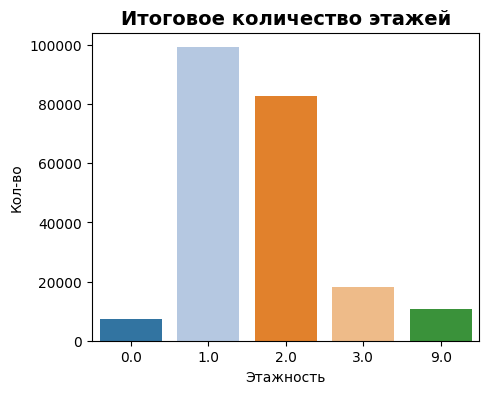

In [140]:
sns_barplot(
    data=   stories_df, 
    title=  'Итоговое количество этажей', 
    size=   (5, 4),
    rotate= 0
)

Из графика хорошо видно, что преобладающее количество объявлений, это малоэтажные строеня в 1-2 этажа

## 2.15 mls-id, MlsId (номер службы множественного листинга)

In [141]:
df[['mls-id', 'MlsId']].head()

,mls-id,MlsId
0,NaN,611019
1,NaN,201916904
2,NaN,FR19221027
3,NaN,14191809
5,NaN,PAPH847006


Поскольку данные признаки являются уникальными номерами специальной службы для риэлторов и не несут никакой значимой иформации, удалим их

In [142]:
df = df.drop(['mls-id', 'MlsId'], axis=1)

df.head(2)

,status,propertyType,baths,fireplace,city,sqft,beds,state,stories,target,...,schools_PK-5,schools_PK-8,schools_PK-12,schools_K,schools_K-5,schools_K-8,schools_K-12,schools_1-5,schools_6-8,schools_9-12
0,active,house,4.0,1,other,2900.0,4.0,NC,NaN,"$418,000",...,2,0,0,3,2,0,1,1,2,2
1,for sale,house,3.0,0,other,1.9,3.0,WA,2.0,"$310,000",...,0,1,0,1,0,1,0,0,1,1


## 2.16 target (цена недвижимости, целевая переменная)

In [143]:
df_value_counts(df['target']).head()

Количество уникальных значений: 42786


,Значение,Кол-во,Доля %
0,"$225,000",1286,0.4
1,"$275,000",1216,0.4
2,"$299,900",1194,0.3
3,"$249,900",1186,0.3
4,"$399,000",1159,0.3


In [144]:
missing_values(df['target'], True)

Количество пропущенных значений 2460, что составляет 1 % от общего количества записей
Количество нулевых значений 0, что составляет 0 % от общего количества записей


Для начала удалим знак $ и округлим значения до одного знака после точки

In [145]:
df['target'] = df['target'].str.replace(r'$', '', regex=True)           # удаление символа $
df['target'] = df['target'].str.replace(r',', '.', regex=True)          # замена , на . (для float)
df['target'] = df['target'].str.replace(r'[^0-9\.]', '', regex=True)    # удаление всех символов кроме цифр
df['target'] = df['target'].str.split('.').str[:2].str.join('.')        # разбиваем значения по точке и берем только первые два элемента
df['target'] = df['target'].astype(float)                               # преобразование во float

In [146]:
df['target'].head()

0    418.000
1    310.000
2      2.895
3      2.395
5    209.000
Name: target, dtype: float64

In [147]:
missing_values(df['target'], True)

Количество пропущенных значений 2460, что составляет 1 % от общего количества записей
Количество нулевых значений 0, что составляет 0 % от общего количества записей


In [148]:
targed_df = df_value_counts(df['target'])

targed_df.head()

Количество уникальных значений: 31221


,Значение,Кол-во,Доля %
0,225.0,1630,0.5
1,275.0,1511,0.4
2,350.0,1498,0.4
3,399.0,1467,0.4
4,325.0,1462,0.4


# 3. Очистка данных

## 3.1 Дубликаты значений

Определим количество дубликатов и удалим их

In [149]:
dupl_columns = list(df.columns)

mask = df.duplicated(subset=dupl_columns)
print(f'Число найденных дубликатов: {df[mask].shape[0]}')

df = df.drop_duplicates()

Число найденных дубликатов: 2388


## 3.2 Пропущенные значения в признаках

Сформируем список, в котором для каждой строки датафрейма будет подсчитано количество пропущенных значений и посмотрим на количество записей, без единого пропуска

In [150]:
missing_values_count    = df.isna().sum(axis=1)                             # количество пропущенных значений в признаках

df_full                 = df[missing_values_count == 0]                     # список значений без пропусков
df_full_percent         = round((df_full.shape[0] / df.shape[0]) * 100)     # процент значений без пропусков

print(f'Количество записей без пропусков {df_full.shape[0]}, что составляет {df_full_percent} % от всего набора данных')

Количество записей без пропусков 55177, что составляет 16 % от всего набора данных


In [151]:
empty_values            = df.isna().sum().values
percentage_empty_values = (empty_values / df.shape[0]) * 100

zero_values             = df[df == 0].count()
percentage_zero_values  = (zero_values / df.shape[0]) * 100

median_values           = df

count_of_empty_values   = pd.DataFrame({
    'Признак': df.columns, 
    'Кол-во пропусков': empty_values,
    'Доля пропусков в %': percentage_empty_values.round(),
    'Кол-во нулевых значений': zero_values,
    'Доля нулей в %': percentage_zero_values.round()
}).sort_values(
    by='Кол-во пропусков', 
    ascending=False, 
    ignore_index=True
)

mask            = count_of_empty_values['Кол-во пропусков'] > 0
empty_values_f  = count_of_empty_values[mask]['Признак'].values

display(count_of_empty_values[mask])

,Признак,Кол-во пропусков,Доля пропусков в %,Кол-во нулевых значений,Доля нулей в %
0,Parking,159619,47.0,0,0.0
1,lotsize,157766,46.0,1,0.0
2,stories,126471,37.0,7233,2.0
3,Cooling,110388,32.0,0,0.0
4,Heating,83526,24.0,0,0.0
5,beds,81898,24.0,1270,0.0
6,baths,79787,23.0,193,0.0
7,status,39403,11.0,0,0.0
8,Price/sqft,37719,11.0,121,0.0
9,Year built,35592,10.0,0,0.0


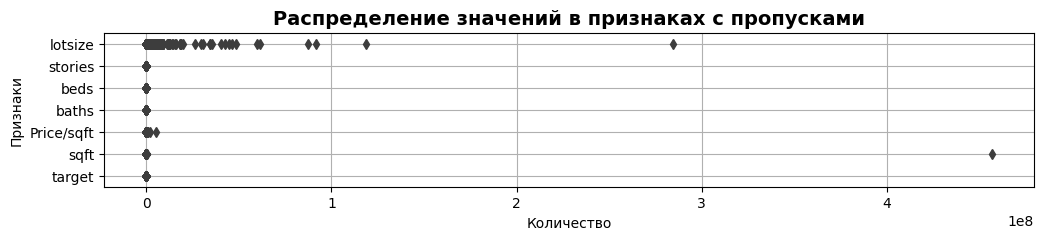

In [152]:
fig, axes = plt.subplots(figsize=(12, 2))

sns.boxplot(
    data=df[empty_values_f],
    orient='h',
    width=0.3
)
axes.set_title(
    'Распределение значений в признаках с пропусками', 
    fontweight='bold', 
    fontsize=14
)
axes.set_xlabel('Количество')
axes.set_ylabel('Признаки')
axes.grid();

В данных присутсвуют ярко выраженные выбросы, которые могут сильно исказить модель.

Удалим все значения, которые больше 1 млн. в следующих признаках - **sqft**, **lotsize**, **beds** и **Price/sqft**

In [153]:
print('Количество удаленных выбросов в признаках:')

sqft_outliers       = df[df['sqft'] > 1e6]
lotsize_outliers    = df[df['lotsize'] > 1e6]
beds_outliers       = df[df['beds'] > 1e6]
price_sqft_outliers = df[df['Price/sqft'] > 1e6]


print(f'sqft - {sqft_outliers.iloc[:, :17].shape[0]}')
print(f'lotsize - {lotsize_outliers.iloc[:, :17].shape[0]}')
print(f'beds - {beds_outliers.iloc[:, :17].shape[0]}')
print(f'Price/sqft - {price_sqft_outliers.iloc[:, :17].shape[0]}')


df = df.drop(sqft_outliers.index, axis=0)
df = df.drop(lotsize_outliers.index, axis=0)
df = df.drop(beds_outliers.index, axis=0)
df = df.drop(price_sqft_outliers.index, axis=0)

Количество удаленных выбросов в признаках:
sqft - 1
lotsize - 388
beds - 0
Price/sqft - 2


Основные, ярковыраженные признаки удалены, теперь можно провести более подробный анализ каждого признака

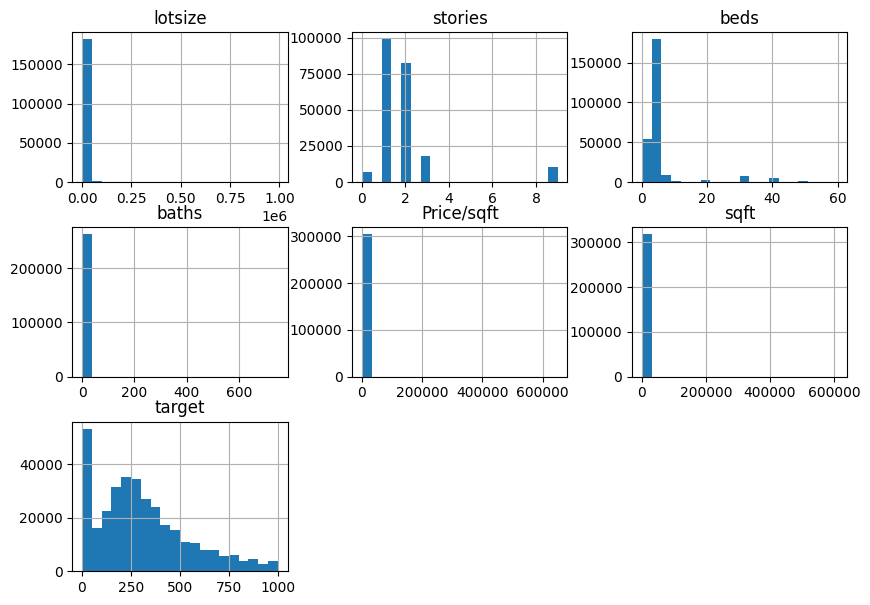

In [154]:
df[empty_values_f].hist(figsize=(10, 7), bins=20);

### sqft

Очистим признак sqft и попробуем извлечь оттуда данные, для заполнения пропусков в этажах

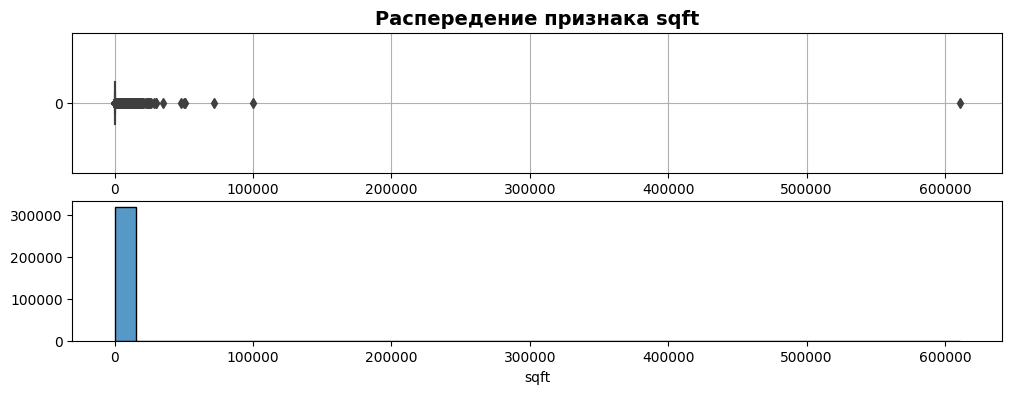

In [155]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))

sns.boxplot(data=df['sqft'], orient='h', width=0.3, ax=axes[0])
axes[0].set_title('Распередение признака sqft', fontweight='bold', fontsize=14)
axes[0].grid()

sns.histplot(data=df['sqft'], bins=40, ax=axes[1])
axes[1].set_ylabel('');

Удалим объекты недвижимости, площадь которых более 30000 sqft

In [156]:
df = df.drop(df[df['sqft'] > 30000].index, axis=0)

Посмотрим на медианные и самые частые значения для разных этажей

In [157]:
stories_median  = df[df['stories'] == 1]['sqft'].median()
stories_mode    = df[df['stories'] == 1]['sqft'].mode()[0]
print(f'Серединное значение для площади одноэтажного дома - {stories_median}, самое частое значение - {stories_mode}')

stories_median  = df[df['stories'] == 2]['sqft'].median()
stories_mode    = df[df['stories'] == 2]['sqft'].mode()[0]
print(f'Серединное значение для площади двухэтажного дома - {stories_median}, самое частое значение - {stories_mode}')

stories_median  = df[df['stories'] == 3]['sqft'].median()
stories_mode    = df[df['stories'] == 3]['sqft'].mode()[0]
print(f'Серединное значение для площади трехэтажного дома - {stories_median}, самое частое значение - {stories_mode}')

Серединное значение для площади одноэтажного дома - 2.0, самое частое значение - 1.2
Серединное значение для площади двухэтажного дома - 2.7, самое частое значение - 2.2
Серединное значение для площади трехэтажного дома - 2.7, самое частое значение - 2.0


Заменим пустые значения в признаке **sqft** исходя из этажности зданий:
* 1 этаж - 1.2 sqft
* 2 этажа - 2.2 sqft
* 3 этажа - 2.7 sqft

In [158]:
df.loc[(df['stories'] == 1) & (df['sqft'].isna()), 'sqft'] = 1.2
df.loc[(df['stories'] == 2) & (df['sqft'].isna()), 'sqft'] = 2.2
df.loc[(df['stories'] == 3) & (df['sqft'].isna()), 'sqft'] = 2.7

df.loc[(df['stories'] == 1) & (df['sqft'] == 0), 'sqft'] = 1.2
df.loc[(df['stories'] == 2) & (df['sqft'] == 0), 'sqft'] = 2.2
df.loc[(df['stories'] == 3) & (df['sqft'] == 0), 'sqft'] = 2.7

Все оставшиеся пропуски заменим медианным значением

In [159]:
df.loc[df['sqft'] == 0, 'sqft']     = df['sqft'].median()
df.loc[df['sqft'].isna(), 'sqft']   = df['sqft'].median()

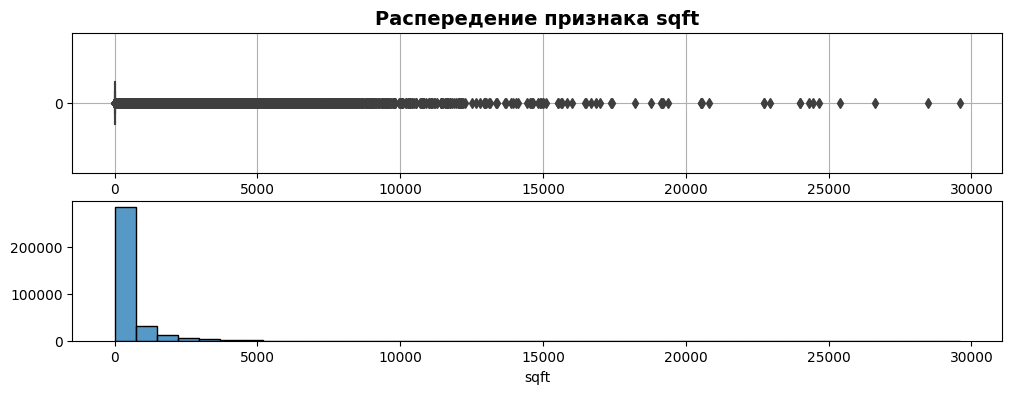

In [160]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))

sns.boxplot(data=df['sqft'], orient='h', width=0.3, ax=axes[0])
axes[0].set_title('Распередение признака sqft', fontweight='bold', fontsize=14)
axes[0].grid()

sns.histplot(data=df['sqft'], bins=40, ax=axes[1])
axes[1].set_ylabel('');

Судя по распределению, в данных присутсвуют объекты недвижимости (в основном дома) с большой площадью, что вполне соответсвует реальности.

### stories

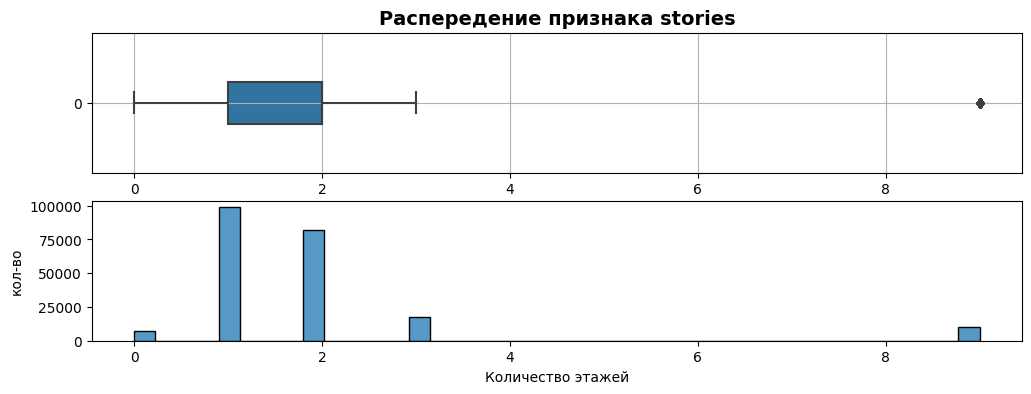

In [161]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))

sns.boxplot(data=df['stories'], orient='h', width=0.3, ax=axes[0])
axes[0].set_title('Распередение признака stories', fontweight='bold', fontsize=14)
axes[0].grid()

sns.histplot(data=df['stories'], bins=40, ax=axes[1])
axes[1].set_ylabel('кол-во')
axes[1].set_xlabel('Количество этажей');

In [162]:
missing_values(df['stories'], True)

Количество пропущенных значений 126306, что составляет 37 % от общего количества записей
Количество нулевых значений 7233, что составляет 2 % от общего количества записей


Ранее, мы получили самый частый размер площади объекта недвижимости относительно количества этажей, применим эти данные для признака **stories** в виде диапазона ±0.2 от полученных результатов
* 1 этаж - 1.0-1.4 sqft
* 2 этажа - 2.0-2.4 sqft
* 3 этажа - 2.5-2.9 sqft

In [163]:
df.loc[(df['sqft'] >= 1.0) & (df['sqft'] <= 1.4) & (df['stories'].isna()), 'stories'] = 1
df.loc[(df['sqft'] >= 2.0) & (df['sqft'] <= 2.4) & (df['stories'].isna()), 'stories'] = 2
df.loc[(df['sqft'] >= 2.5) & (df['sqft'] <= 2.7) & (df['stories'].isna()), 'stories'] = 3

df.loc[(df['sqft'] >= 1.0) & (df['sqft'] <= 1.4) & (df['stories'] == 0), 'stories'] = 1
df.loc[(df['sqft'] >= 2.0) & (df['sqft'] <= 2.4) & (df['stories'] == 0), 'stories'] = 2
df.loc[(df['sqft'] >= 2.5) & (df['sqft'] <= 2.7) & (df['stories'] == 0), 'stories'] = 3

In [164]:
missing_values(df['stories'], True)

Количество пропущенных значений 62461, что составляет 18 % от общего количества записей
Количество нулевых значений 4042, что составляет 1 % от общего количества записей


In [165]:
less_than_one       = df[df['stories'] < 1]
less_than_one_p     = round((less_than_one.shape[0] / df.shape[0]) * 100)

more_than_three     = df[df['stories'] > 3]
more_than_three_p   = round((more_than_three.shape[0] / df.shape[0]) * 100)

print(f'Количество значений менее 1 = {less_than_one.shape[0]}, что составляет {less_than_one_p} % от общего числа записей')
print(f'Количество значений более 3 = {more_than_three.shape[0]}, что составляет {more_than_three_p} % от общего числа записей')

Количество значений менее 1 = 4042, что составляет 1 % от общего числа записей
Количество значений более 3 = 10512, что составляет 3 % от общего числа записей


Заменим все нулевые значения на 1, будем считать что в каждый объект недвижимости имеет хотя-бы один этаж. К тому же, из данных видно, что обекты с нулевым этажем имеют тип строения - house, разное количество спален, ванных комнат, площади и т.п.

In [166]:
df.loc[less_than_one.index, 'stories'] = 1

Поскольку данных для объектов недвижимости более трех этажей не так много, удалим их, чтобы распределение по этажам было более равномерное

In [167]:
df = df.drop(more_than_three.index, axis=0)

### Parking, Cooling, Heating

В признаках **Parking, Cooling, Heating** присутсвует слишком много пропусков, заменим их на **no data** чтобы не потерять потенциально полезные признаки и не исказить данные простой заменой на самое частое значение.

In [168]:
df.loc[df['Parking'].isna(), 'Parking'] = 'no data'
df.loc[df['Cooling'].isna(), 'Cooling'] = 'no data'
df.loc[df['Heating'].isna(), 'Heating'] = 'no data'

## 3.3 Замена пропусков в оставшихся признаках

In [169]:
st_mode = df['status'].mode()[0]
pt_mode = df['propertyType'].mode()[0]
yb_mode = df['Year built'].mode()[0]
sr_mode = df['stories'].mode()[0]
ba_mode = df['baths'].mode()[0]
be_mode = df['beds'].mode()[0]
lo_mode = df['lotsize'].mode()[0]


df.loc[df['status'].isna(), 'status']               = st_mode
df.loc[df['propertyType'].isna(), 'propertyType']   = pt_mode
df.loc[df['Year built'].isna(), 'Year built']       = yb_mode
df.loc[df['stories'].isna(), 'stories']             = sr_mode
df.loc[df['baths'].isna(), 'baths']                 = ba_mode
df.loc[df['baths'] == 0, 'baths']                   = ba_mode
df.loc[df['beds'].isna(), 'beds']                   = be_mode
df.loc[df['lotsize'].isna(), 'lotsize']             = be_mode
df.loc[df['lotsize'] == 0, 'lotsize']               = lo_mode

In [170]:
ta_median = df['target'].median()
ps_median = df['Price/sqft'].median()


df.loc[df['target'].isna(), 'target']           = ta_median
df.loc[df['Price/sqft'].isna(), 'Price/sqft']   = ps_median
df.loc[df['Price/sqft'] == 0, 'Price/sqft']     = ps_median

Преобразуем год в формат DateTime, для последующего анализа, для этого добавим к каждому значению окончание в виде месяца и дня.

In [171]:
df['Year built'] = df['Year built'] + '-01-01'

Отобразим слишком старые года, которые не входят в формат DateTime

In [172]:
yb_errors = df['Year built'].sort_values()[:4]

df.loc[yb_errors.index, :'Year built']

,status,propertyType,baths,fireplace,city,sqft,beds,state,stories,target,private_pool,Year built
312874,active,other,3.0,0,Charlotte,1.8,3.0,NC,1.0,285.500,0,1019-01-01
172723,active,house,2.0,0,Ocala,1042.0,2.0,FL,1.0,104.900,0,1057-01-01
264054,active,house,2.0,0,Brooklyn,1.9,3.0,NY,1.0,1.499,0,1060-01-01
149924,other,house,2.0,0,other,1208.0,30.0,OH,1.0,79.000,0,1208-01-01


И удалим их

In [173]:
df = df.drop(yb_errors.index, axis=0)

Приведем все признаки к правильным форматам данных

In [174]:
df['Year built']    = pd.to_datetime(df['Year built'])
df['baths']         = df['baths'].astype(int)
df['beds']          = df['beds'].astype(int)
df['stories']       = df['stories'].astype(int)

## 3.4 Очистка выбрососв

Очистим от выбросов числовые признаки

In [175]:
original_shape = df.shape[0]

_, df = outliers_z_score_mod(df, 'baths', left=1.5, right=0.4)
_, df = outliers_z_score_mod(df, 'sqft', left=1.5, right=6)
_, df = outliers_z_score_mod(df, 'lotsize', left=1.5, right=4)
_, df = outliers_z_score_mod(df, 'Price/sqft', left=1.5, right=0.5)
_, df = outliers_z_score_mod(df, 'schools_distance_min', left=1.5, right=2)
_, df = outliers_z_score_mod(df, 'schools_distance_mean', left=1.5, right=3)
_, df = outliers_z_score_mod(df, 'schools_distance_max', left=1.5, right=4)

_, df = outliers_z_score_mod(df, 'schools_PK–2',   left=1.5, right=4)
_, df = outliers_z_score_mod(df, 'schools_PK-5',   left=1.5, right=4)
_, df = outliers_z_score_mod(df, 'schools_PK-8',   left=1.5, right=3)
_, df = outliers_z_score_mod(df, 'schools_PK-12',  left=1.5, right=3.5)
_, df = outliers_z_score_mod(df, 'schools_K',      left=1.5, right=5)
_, df = outliers_z_score_mod(df, 'schools_K-5',    left=1.5, right=5)
_, df = outliers_z_score_mod(df, 'schools_K-8',    left=1.5, right=3)
_, df = outliers_z_score_mod(df, 'schools_K-12',   left=1.5, right=4)
_, df = outliers_z_score_mod(df, 'schools_6-8',    left=1.5, right=7)


cleaned_shape = df.shape[0]
print(f'Количество удаленных выбросов: {original_shape - cleaned_shape}')

Количество удаленных выбросов: 86134


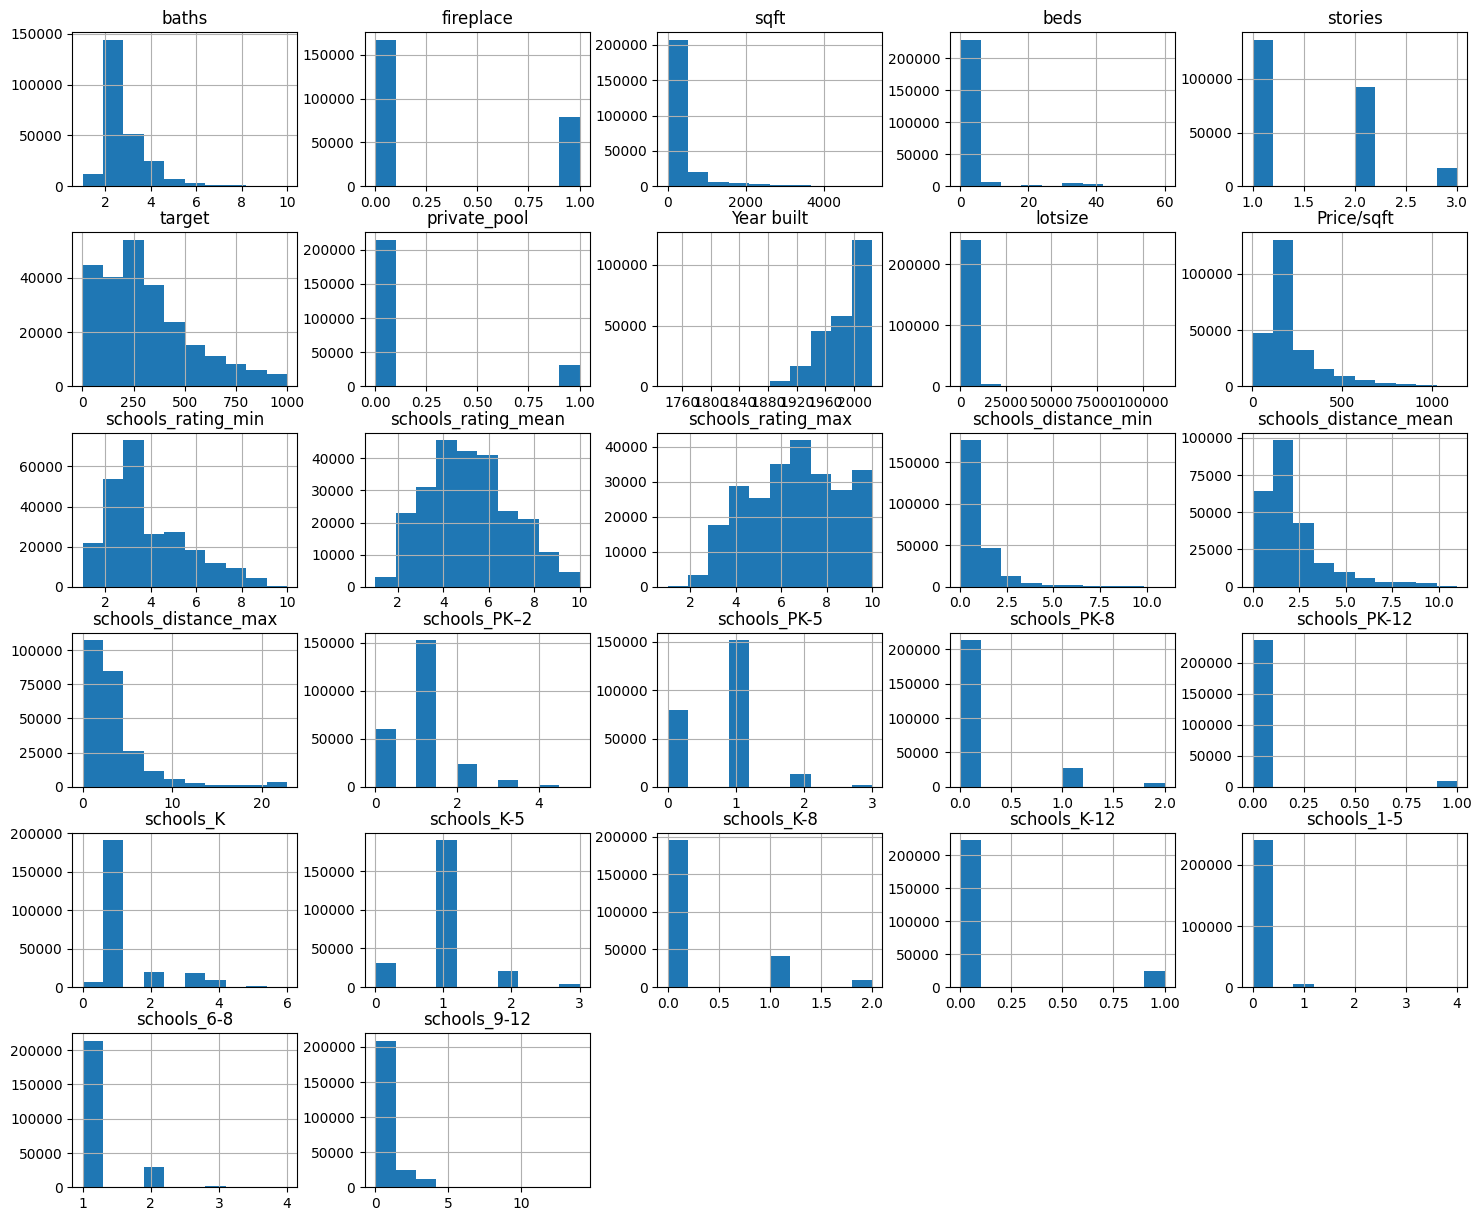

In [176]:
df.hist(figsize=(18, 15));

Разделим признаки на числовые и категориальные

In [177]:
cat_cols = df.select_dtypes(include=['object', 'datetime64[ns]']).columns
num_cols = df.select_dtypes(exclude=['object']).columns

Выполним проверку на мультиколлинеарность для числовых признаков

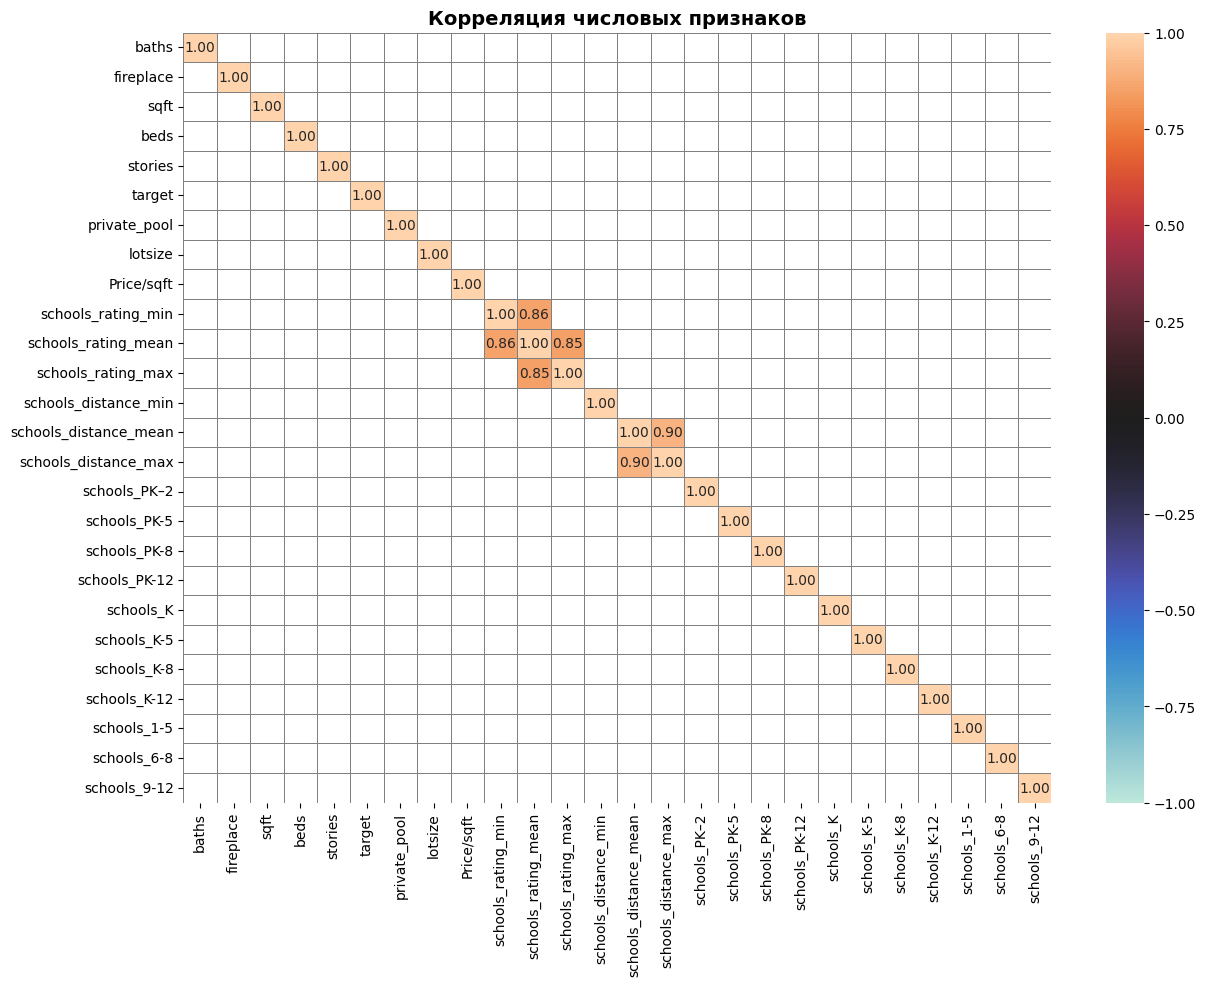

In [178]:
corr = df[num_cols].corr(numeric_only=True)     # корреляция числовых признаков
corr = corr[np.abs(corr) >= 0.8]

plt.subplots(figsize=(14,10))
heatmap = sns.heatmap(
    corr, 
    annot=True, 
    linewidths=0.5, 
    vmin=-1, 
    vmax=1, 
    center= 0,
    fmt='.2f',
    linecolor='grey')
heatmap.set_title('Корреляция числовых признаков', fontweight='bold', size=14);

Удалим сильно скоррелированые признаки и обновим список числовых признаков

In [179]:
df = df.drop(['schools_distance_max', 'schools_rating_min'], axis=1)

num_cols = df.select_dtypes(exclude=['object']).columns

# 4. Анализ данных

## 4.1 Проверка нормальности распределения

In [180]:
H0 = 'Данные распределены нормально'
H1 = 'Данные не распределены нормально'
alpha = 0.05

col_list = ['baths', 'fireplace', 'sqft', 'beds',
       'stories', 'target', 'private_pool',
       'lotsize', 'Price/sqft', 'schools_rating_mean',
       'schools_rating_max', 'schools_distance_min', 'schools_distance_mean',
       'schools_PK–2', 'schools_PK-5', 'schools_PK-8', 'schools_PK-12',
       'schools_K', 'schools_K-5', 'schools_K-8', 'schools_K-12',
       'schools_1-5', 'schools_6-8', 'schools_9-12']

for col in col_list:
    statistic, p_value = normaltest(df[col])

    if p_value > alpha:
        print(f'{H0} ({col})')
    else:
        print(f'{H1} ({col})')

Данные не распределены нормально (baths)
Данные не распределены нормально (fireplace)
Данные не распределены нормально (sqft)
Данные не распределены нормально (beds)
Данные не распределены нормально (stories)
Данные не распределены нормально (target)
Данные не распределены нормально (private_pool)
Данные не распределены нормально (lotsize)
Данные не распределены нормально (Price/sqft)
Данные не распределены нормально (schools_rating_mean)
Данные не распределены нормально (schools_rating_max)
Данные не распределены нормально (schools_distance_min)
Данные не распределены нормально (schools_distance_mean)
Данные не распределены нормально (schools_PK–2)
Данные не распределены нормально (schools_PK-5)
Данные не распределены нормально (schools_PK-8)
Данные не распределены нормально (schools_PK-12)
Данные не распределены нормально (schools_K)
Данные не распределены нормально (schools_K-5)
Данные не распределены нормально (schools_K-8)
Данные не распределены нормально (schools_K-12)
Данные не 

**Данные не распределены нормально, для проверки гипотиз будем использовать непараметрические тесты, такие как тест Флигнера-Киллена и тест Брауна-Форсайта.**

## 4.2 Проверка гипотиз

**Проверка равенства дисперсий**

Сравним дисперсии цен между различными типами недвижимости **house (дома)** и **apartment (квартиры)**.

Проверим гипотезу о равенстве дисперсий для различных типов объектов недвижимости (propertyType)

In [181]:
H0 = 'Дисперсии цен (target) для всех типов объектов недвижимости равны.'
H1 = 'Дисперсии цен (target) для различных типов объектов недвижимости различаются.'
alpha = 0.05

# Тест Флигнера-Киллена
statistic, p_value = fligner(df['target'][df['propertyType'] == 'house'], df['target'][df['propertyType'] == 'apartment'])
print("Тест Флигнера-Киллена - Statistic:", statistic.round(2), "p-value:", p_value.round(2))
if p_value < alpha:
    print(H1)
else:
    print(H0)

print()

# Тест Брауна-Форсайта
statistic, p_value = levene(df['target'][df['propertyType'] == 'house'], df['target'][df['propertyType'] == 'apartment'], center='median')
print("Тест Брауна-Форсайта - Statistic:", statistic.round(2), "p-value:", p_value.round(2))
if p_value < alpha:
    print(H1)
else:
    print(H0)


Тест Флигнера-Киллена - Statistic: 170.56 p-value: 0.0
Дисперсии цен (target) для различных типов объектов недвижимости различаются.

Тест Брауна-Форсайта - Statistic: 214.36 p-value: 0.0
Дисперсии цен (target) для различных типов объектов недвижимости различаются.


**Поскольку p-value меньше уровня значимости, отвергаем нулевую гипотезу и можно сделать вывод о наличии статистически значимых различий в дисперсиях цен.**

***

Сравним дисперсии цен между наиболее распространенными городами **Houston** и **San Antonio**.

Проверим гипотезу о равенстве дисперсий для разных городов (city)

In [182]:
H0 = 'Дисперсии цен (target) для всех городов равны.'
H1 = 'Дисперсии цен (target) для разных городов различаются.'
alpha = 0.05

# Тест Флигнера-Киллена
statistic, p_value = fligner(df['target'][df['city'] == 'Houston'], df['target'][df['city'] == 'San Antonio'])
print("Тест Флигнера-Киллена - Statistic:", statistic.round(2), "p-value:", p_value.round(2))
if p_value < alpha:
    print(H1)
else:
    print(H0)

print()

# Тест Брауна-Форсайта
statistic, p_value = levene(df['target'][df['city'] == 'Houston'], df['target'][df['city'] == 'San Antonio'], center='median')
print("Тест Брауна-Форсайта - Statistic:", statistic.round(2), "p-value:", p_value.round(2))
if p_value < alpha:
    print(H1)
else:
    print(H0)


Тест Флигнера-Киллена - Statistic: 1946.16 p-value: 0.0
Дисперсии цен (target) для разных городов различаются.

Тест Брауна-Форсайта - Statistic: 1710.59 p-value: 0.0
Дисперсии цен (target) для разных городов различаются.


**Поскольку p-value меньше уровня значимости, отвергаем нулевую гипотезу и делаем вывод о наличии статистически значимых различий в дисперсиях цен между городами.**

***

## 4.3 Визуальный анализ данных

Посмотрим на разницу в стоимости недвижимости относительно штата

In [183]:
mean_price_state = df.pivot_table(
    values='target', 
    index='state', 
    aggfunc='mean')


fig_mps = px.choropleth(
    data_frame = mean_price_state, 
    locations = mean_price_state.index, 
    locationmode="USA-states", 
    color = mean_price_state['target'].values,
    range_color = [0, mean_price_state.max()[0]], 
    scope='usa',
    width = 1000, 
    height = 500, 
    color_continuous_scale = 'portland',
    title='Средняя стоимость недвижимости, в зависимости от штата'
    );

fig_mps.update_traces(
    hovertemplate='<b>Штат = %{location}</b><br><b>Ср. стоимость</b> = %{z:,}'
)
fig_mps.update_layout(
    coloraxis_colorbar_title='Ср. стоимость'
)

fig_mps.show();

Можно сделать вывод, что недвижимость имеет более высокую цену в западных штатах, по сравнению с центральной и северной частью США.

***

Посмотрим на зависимость стоимости от площади объекта

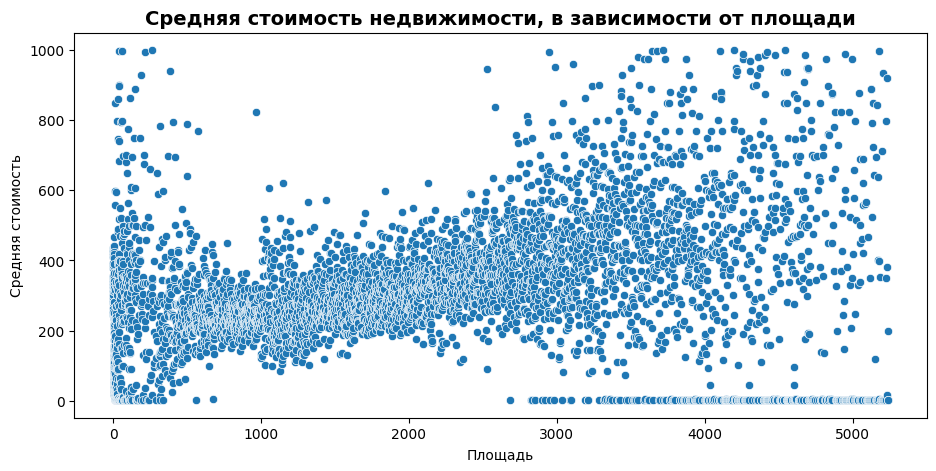

In [184]:
mean_price_sqft = df.pivot_table(
    values='target', 
    index='sqft', 
    aggfunc='mean')


fig, ax = plt.subplots(figsize=(11, 5))
sns.scatterplot(
    data = mean_price_sqft,
    x = mean_price_sqft.index, 
    y = 'target')
ax.set_xlabel('Площадь')
ax.set_ylabel('Средняя стоимость')
plt.title(
    'Средняя стоимость недвижимости, в зависимости от площади', 
    fontweight='bold', 
    fontsize=14);

В середине графике хорошо разлечим основной диапазон цен на недвижимость, в пределах стоимости от 100 до 500 и площади от 200 до 3500 sqft. Так же хорошо заметна тенденция к увеличению разброса и разряжению данных в области высоких цен и больших площадей. Таких объектов недвижимости на самом деле не так много по сравнению с основной массой объявлений.

***

Проанализируем изменения средней стоимости объектов недвижимости со временем

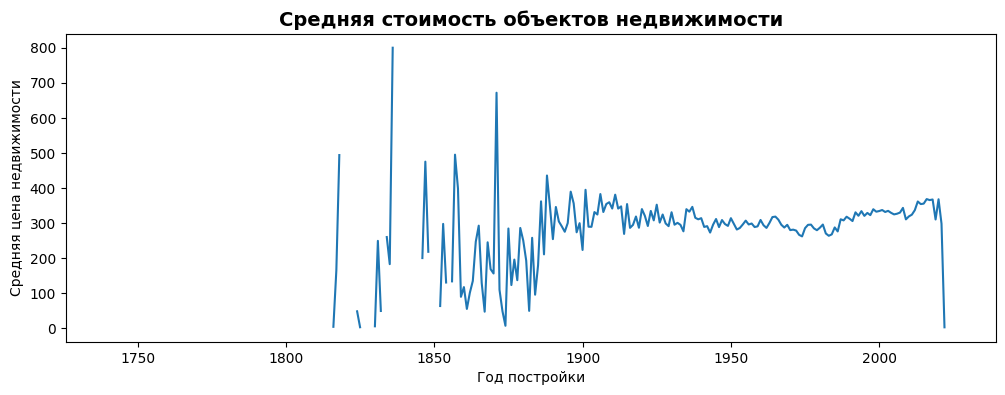

In [185]:
df_yb = df.copy()
df_yb.set_index('Year built', inplace=True)

average_price_by_year = df_yb.resample('Y').mean(numeric_only=True)['target']

fig = plt.subplots(figsize=(12, 4))

plt.plot(
    average_price_by_year.index.year, 
    average_price_by_year.values)
plt.xlabel('Год постройки')
plt.ylabel('Средняя цена недвижимости')
plt.title(
    'Средняя стоимость объектов недвижимости', 
    fontweight='bold', 
    fontsize=14)
plt.show();

Из графика видно, что недвижимость, построенная до 1900 года сильно изменяется в цене, что может говорить о исторической значимости при высоких ценах и наоборот, ветхом, заброшенном строении при низкой цене за объект недвижимости. После примерно 1970 года наблюдается стабильный небольшой рост цен на недвижимость.

# 5. Подготовка признаков для обучения модели

Выполним кодирование категориальных признаков

In [186]:
df[cat_cols].nunique()

status            3
propertyType      5
city            249
state            34
Year built      201
Heating           6
Cooling           6
Parking           4
dtype: int64

Судя по количеству уникальных значений, закодируем признаки следующим образом:
* **One Hot encoding**
    * status
    * propertyType
    * Heating
    * Cooling
    * Parking
* **Label encoding**
    * city
    * state
    * Year built

In [187]:
OHT_features    = df[['status', 'propertyType', 'Heating', 'Cooling', 'Parking']]
OHT_df          = pd.get_dummies(OHT_features)

df = pd.concat([df, OHT_df], axis=1)
df = df.drop(OHT_features.columns, axis=1)

In [188]:
LE_city             = LabelEncoder()
LE_state            = LabelEncoder()
LE_year_built       = LabelEncoder()

df['city']          = LE_city.fit_transform(df['city'])
df['state']         = LE_state.fit_transform(df['state'])
df['Year built']    = LE_year_built.fit_transform(df['Year built'])

Обновим список категориальных признаков

In [189]:
cat_cols = ['city', 'state', 'Year built', 'status_active', 
            'status_for sale', 'status_other', 
            'propertyType_apartment', 'propertyType_house',
            'propertyType_multi family', 'propertyType_other',
            'propertyType_townhouse', 'Heating_air', 
            'Heating_central', 'Heating_electric', 'Heating_gas', 
            'Heating_no data', 'Heating_other','Cooling_central', 
            'Cooling_cooling', 'Cooling_no data', 'Cooling_other', 
            'Cooling_refrigeration', 'Cooling_wall', 'Parking_garage', 
            'Parking_no data', 'Parking_other', 'Parking_parking']

Выполним проверку на мультиколлинеарность для категориальных признаков

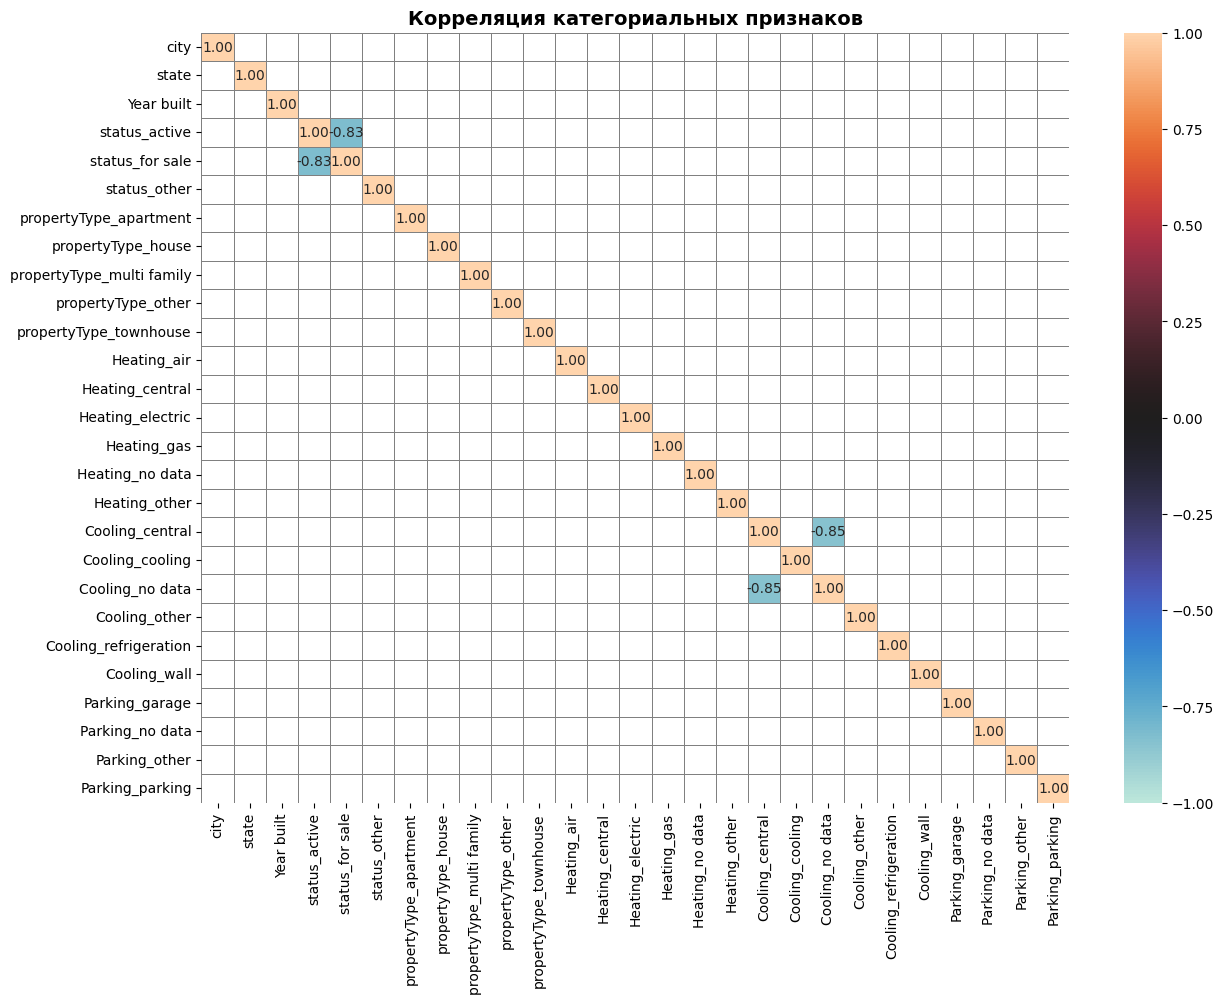

In [190]:
corr = df[cat_cols].corr(method='spearman')
corr = corr[np.abs(corr) >= 0.8]

plt.subplots(figsize=(14, 10))
heatmap = sns.heatmap(
    corr, 
    annot=True, 
    linewidths=0.5, 
    vmin=-1, 
    vmax=1, 
    center= 0, 
    fmt='.2f',
    linecolor='grey')
heatmap.set_title('Корреляция категориальных признаков', fontweight='bold', size=14);

Удалим только один признак - **Cooling_no data**

In [191]:
df = df.drop('Cooling_no data', axis=1)

Разделим DataFrame на основной набор данных и целевую переменную

In [192]:
X = df.drop('target', axis=1)
y = df['target']

Обновим список категориальных и числовых переменных

In [193]:
cat_cols = ['city', 'state', 'Year built', 'status_active', 
            'status_for sale', 'status_other', 
            'propertyType_apartment', 'propertyType_house',
            'propertyType_multi family', 'propertyType_other',
            'propertyType_townhouse', 'Heating_air', 
            'Heating_central', 'Heating_electric', 'Heating_gas', 
            'Heating_no data', 'Heating_other','Cooling_central', 
            'Cooling_cooling', 'Cooling_other', 'Cooling_refrigeration', 
            'Cooling_wall', 'Parking_garage', 'Parking_no data', 
            'Parking_other', 'Parking_parking']

num_cols = ['baths', 'fireplace', 'sqft', 'beds', 'stories', 'private_pool', 
            'lotsize', 'Price/sqft', 'schools_rating_mean', 
            'schools_rating_max', 'schools_distance_min',
            'schools_distance_mean', 'schools_PK–2', 'schools_PK-5', 
            'schools_PK-8', 'schools_PK-12', 'schools_K', 'schools_K-5', 
            'schools_K-8', 'schools_K-12', 'schools_1-5', 'schools_6-8', 
            'schools_9-12']

**Выполним ANOVA тест для оценки значимости числовых переменных**

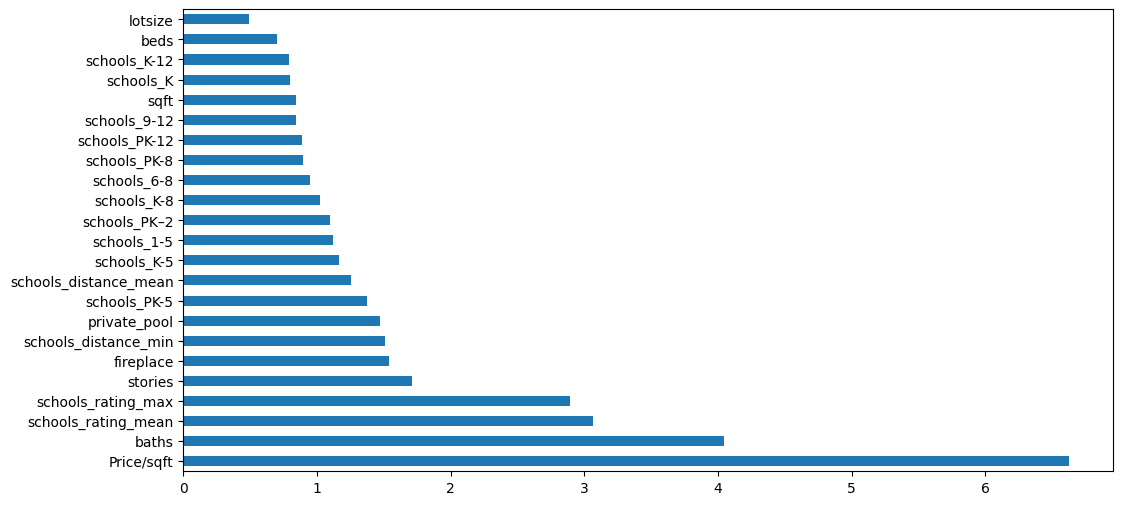

In [194]:
plt.rcParams['figure.figsize'] = (12,6)

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True, ascending = False)
imp_num.plot(kind = 'barh');

Все числовые признаки являются достаточно значимыми для целевой переменной, особенно такие как максимальный и средний рейтинг школ, количество ванных комнат и цена за квадратный фут

**Выполним непараметрический тест хи-квадрат для оценки значимости категориальных переменных**

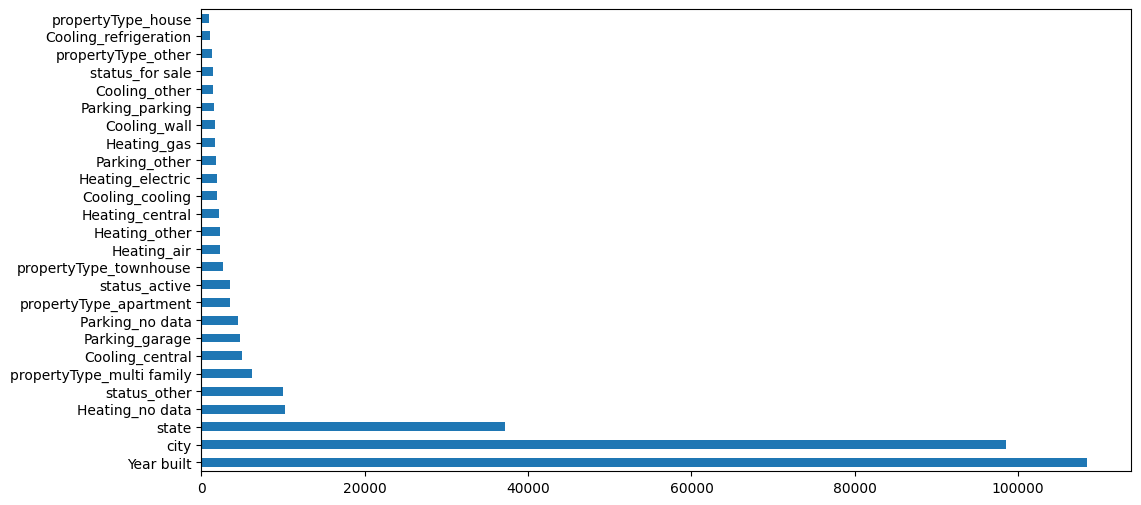

In [195]:
plt.rcParams['figure.figsize'] = (12,6)

y_int = y.astype('int')
imp_cat = pd.Series(chi2(X[cat_cols], y_int)[0], index=cat_cols)
imp_cat.sort_values(inplace = True, ascending = False)
imp_cat.plot(kind = 'barh');

Достаточно важными признаками оказались год постройки, город, штат, тип и статус жилья

**Обработка и анализ данных окончены, сохраним данные в файл**

In [196]:
df.to_csv('../data/processed_data.csv', index=False)